In [179]:
# CSc 59866 L - Senior Project I - Modeling of Complex Systems - Dynamics Between Health and Poverty in the US (2015-2025)

In [180]:
# requires duckdb to handle CSVs outside of RAM; SQL syntax

In [303]:
import pandas as pd
import numpy as np
import glob
import os
import duckdb
import gc

from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

In [182]:
# datasets
# https://github.com/google-research/population-dynamics -- conus27, poverty, unemployment
# https://www.countyhealthrankings.org/health-data/methodology-and-sources/data-documentation -- county & health outcomes & indicators
# https://rowzero.io/workbook/8DBEAEC93C53EF406AFD4543/163?ref=fips-codes -- ZIP to County FIPS codes
# reference
# https://www.bls.gov/respondents/mwr/electronic-data-interchange/appendix-d-usps-state-abbreviations-and-fips-codes.htm

In [3]:
# load
conus = pd.read_csv('./data/raw/Population Dynamics (PDFM)/conus27.csv')     # health/geospatial -- not annual; supplemented by countyhealthrankings
poverty = pd.read_csv('./data/raw/Population Dynamics (PDFM)/zcta_poverty.csv')     # ZCTA poverty rates
unemployment = pd.read_csv('./data/raw/Population Dynamics (PDFM)/county_unemployment.csv')     # county unemployment

In [4]:
print("conus27 - location information (place, county, state, latitude, longitude) and key population health indicators")
conus.head()

conus27 - location information (place, county, state, latitude, longitude) and key population health indicators


place           county state   latitude   longitude  Count_Person  \
0  zip/97910   Malheur County    OR  42.749076 -117.511459           609   
1  zip/89412    Washoe County    NV  41.102934 -119.695361            98   
2  zip/88030      Luna County    NM  32.191634 -107.729431         24139   
3  zip/82633  Converse County    WY  43.022270 -105.410250          9478   
4  zip/59538  Phillips County    MT  48.112019 -107.845520          2936   

   Percent_Person_WithHighCholesterol  \
0                                36.7   
1                                40.1   
2                                39.1   
3                                31.3   
4                                35.3   

   Percent_Person_WithPhysicalHealthNotGood  Percent_Person_WithStroke  \
0                                      15.5                        4.4   
1                                      13.1                        3.5   
2                                      16.9                        4.7   
3                                      11.4                        2.8   
4                                      13.4                        4.0   

   Percent_Person_BingeDrinking  ...  Percent_Person_Smoking  \
0                          14.3  ...                    19.8   
1                          17.0  ...                    17.1   
2                          11.6  ...                    19.5   
3                          18.1  ...                    18.4   
4                          17.9  ...                    17.7   

   Median_Income_Household  \
0                  62188.0   
1                  43041.0   
2                  40075.0   
3                  80962.0   
4                  65670.0   

   Median_HomeValue_HousingUnit_OccupiedHousingUnit_OwnerOccupied  \
0                                           208900.0                
1                                           192700.0                
2                                           104300.0                
3                                           259500.0                
4                                           179400.0                

   night_lights_log10  population_density_log10  tree_cover    elevation  \
0            0.119447                  0.019265    0.965506  1431.150194   
1            0.115873                  0.005574    2.539669  1644.526874   
2            0.161864                  0.664501    0.235032  1373.998924   
3            0.189975                  0.334621    4.257895  1590.379821   
4            0.143312                  0.158791    0.981226   773.187494   

   imputation_split  superresolution_split  extrapolation_split  
0            valid4                  valid               valid2  
1            valid5                  valid                 test  
2            valid3                  valid                 test  
3            valid4                  valid                 test  
4            valid5                  valid               valid4  

[5 rows x 36 columns]

In [5]:
print("poverty - annual poverty estimates at the ZIP Code Tabulation Area (ZCTA) level from 2011 to 2022")
poverty.head()

poverty - annual poverty estimates at the ZIP Code Tabulation Area (ZCTA) level from 2011 to 2022


place    2011    2012    2013    2014    2015    2016    2017    2018  \
0  zip/01001  0.0851  0.0720  0.0891  0.0811  0.0716  0.0839  0.0888  0.0859   
1  zip/01002  0.2093  0.2189  0.2535  0.2605  0.2728  0.2786  0.2593  0.2374   
2  zip/01003  0.0000  0.0001  0.0001  0.0001  0.0039  0.0048  0.0051  0.0058   
3  zip/01005  0.0442  0.0463  0.0469  0.0438  0.0519  0.0440  0.0612  0.0667   
4  zip/01007  0.0456  0.0596  0.0831  0.0770  0.0913  0.0947  0.0574  0.0524   

     2019    2020    2021    2022  
0  0.0818  0.0810  0.0738  0.0692  
1  0.2148  0.1967  0.2009  0.1932  
2  0.0061  0.0021  0.0002  0.0003  
3  0.0833  0.1072  0.1148  0.0868  
4  0.0604  0.0495  0.0708  0.0825

In [6]:
print("unemployment - county-level unemployment data over a monthly timespan from 1990 to 2024")
unemployment.head()

unemployment - county-level unemployment data over a monthly timespan from 1990 to 2024


place  1990-01  1990-02  1990-03  1990-04  1990-05  1990-06  1990-07  \
0  geoId/01001      6.5      6.5      5.7      6.6      6.0      7.1      6.0   
1  geoId/01003      6.4      6.1      5.3      4.8      4.3      4.8      4.9   
2  geoId/01005      7.2      7.2      6.3      7.5      7.6      9.0      7.9   
3  geoId/01007     12.6      9.7      5.4      5.5      4.8      6.2      5.6   
4  geoId/01009      5.3      5.9     10.9      5.6      5.3      5.8      5.7   

   1990-08  1990-09  ...  2023-07  2023-08  2023-09  2023-10  2023-11  \
0      6.7      7.3  ...      2.3      2.5      2.3      2.3      2.2   
1      4.9      5.3  ...      2.3      2.5      2.5      2.4      2.3   
2      9.0      9.0  ...      4.8      5.0      4.4      4.5      4.3   
3     15.8      9.1  ...      2.7      2.9      2.6      2.5      2.5   
4      6.5      6.3  ...      2.3      2.4      2.4      2.2      2.2   

   2023-12  2024-01  2024-02  2024-03  2024-04  
0      2.2      2.7      3.0      2.6      2.3  
1      2.5      3.2      3.2      2.9      2.5  
2      4.6      5.4      5.8      4.9      4.1  
3      2.5      3.1      3.4      3.0      2.5  
4      2.3      3.0      3.1      2.7      2.4  

[5 rows x 413 columns]

In [53]:
print("countyhealthrankings - location and population health & wellbeing, community conditions (infrastructure & environment) -- outcomes & factors")

countyhealthrankings - location and population health & wellbeing, community conditions (infrastructure & environment) -- outcomes & factors


In [94]:
# load health/geospatial data -- for years 2023-2025
# health15 = pd.read_csv('./data/raw/County Health Rankings/analytic_data2015.csv', header=0, skiprows=[1, 2])
# health16 = pd.read_csv('./data/raw/County Health Rankings/analytic_data2016.csv', header=0, skiprows=[1, 2])
# health17 = pd.read_csv('./data/raw/County Health Rankings/analytic_data2017.csv', header=0, skiprows=[1, 2])
# health18 = pd.read_csv('./data/raw/County Health Rankings/analytic_data2018_0.csv', header=0, skiprows=[1, 2])
# health19 = pd.read_csv('./data/raw/County Health Rankings/analytic_data2019.csv', header=0, skiprows=[1, 2])
# health20 = pd.read_csv('./data/raw/County Health Rankings/analytic_data2020_0.csv', header=0, skiprows=[1, 2])
# health21 = pd.read_csv('./data/raw/County Health Rankings/analytic_data2021.csv', header=0, skiprows=[1, 2])
# health22 = pd.read_csv('./data/raw/County Health Rankings/analytic_data2022.csv', header=0, skiprows=[1, 2])
# health23 = pd.read_csv('./data/raw/County Health Rankings/analytic_data2023_0.csv', header=0, skiprows=[1, 2])
# health24 = pd.read_csv('./data/raw/County Health Rankings/analytic_data2024.csv', header=0, skiprows=[1, 2])
# health25 = pd.read_csv('./data/raw/County Health Rankings/analytic_data2025.csv', header=0, skiprows=[1, 2])

In [54]:
print("\n2015")
health15.head()


2015


State FIPS Code  County FIPS Code  5-digit FIPS Code State Abbreviation  \
0                1                 0               1000                 AL   
1                1                 1               1001                 AL   
2                1                 3               1003                 AL   
3                1                 5               1005                 AL   
4                1                 7               1007                 AL   

             Name  Release Year  County Ranked (Yes=1/No=0)  \
0         Alabama          2015                         NaN   
1  Autauga County          2015                         1.0   
2  Baldwin County          2015                         1.0   
3  Barbour County          2015                         1.0   
4     Bibb County          2015                         1.0   

   Premature death raw value  Premature death numerator  \
0                    9507.90                    72385.0   
1                    8405.21                      754.0   
2                    7456.89                     2460.0   
3                    8900.51                      414.0   
4                   10729.22                      407.0   

   Premature death denominator  ...  Male population 18-44 raw value  \
0                   13527993.0  ...                              NaN   
1                     157345.0  ...                              NaN   
2                     519994.0  ...                              NaN   
3                      76718.0  ...                              NaN   
4                      64629.0  ...                              NaN   

   Male population 45-64 raw value  Male population 65+ raw value  \
0                              NaN                            NaN   
1                              NaN                            NaN   
2                              NaN                            NaN   
3                              NaN                            NaN   
4                              NaN                            NaN   

   Total male population raw value  Female population 0-17 raw value  \
0                              NaN                               NaN   
1                              NaN                               NaN   
2                              NaN                               NaN   
3                              NaN                               NaN   
4                              NaN                               NaN   

   Female population 18-44 raw value  Female population 45-64 raw value  \
0                                NaN                                NaN   
1                                NaN                                NaN   
2                                NaN                                NaN   
3                                NaN                                NaN   
4                                NaN                                NaN   

   Female population 65+ raw value  Total female population raw value  \
0                              NaN                                NaN   
1                              NaN                                NaN   
2                              NaN                                NaN   
3                              NaN                                NaN   
4                              NaN                                NaN   

   Population growth raw value  
0                          NaN  
1                          NaN  
2                          NaN  
3                          NaN  
4                          NaN  

[5 rows x 462 columns]

In [55]:
print("\n2016")
health16.head()


2016


State FIPS Code  County FIPS Code  5-digit FIPS Code State Abbreviation  \
0                1                 0               1000                 AL   
1                1                 1               1001                 AL   
2                1                 3               1003                 AL   
3                1                 5               1005                 AL   
4                1                 7               1007                 AL   

             Name  Release Year  County Ranked (Yes=1/No=0)  \
0         Alabama          2016                         NaN   
1  Autauga County          2016                         1.0   
2  Baldwin County          2016                         1.0   
3  Barbour County          2016                         1.0   
4     Bibb County          2016                         1.0   

   Premature death raw value  Premature death numerator  \
0                     9544.7                    73929.0   
1                     9215.1                      809.0   
2                     7454.6                     2506.0   
3                     8499.9                      410.0   
4                    11007.7                      414.0   

   Premature death denominator  ...  Male population 18-44 raw value  \
0                   13566808.0  ...                              NaN   
1                     157582.0  ...                              NaN   
2                     531694.0  ...                              NaN   
3                      76276.0  ...                              NaN   
4                      64139.0  ...                              NaN   

   Male population 45-64 raw value  Male population 65+ raw value  \
0                              NaN                            NaN   
1                              NaN                            NaN   
2                              NaN                            NaN   
3                              NaN                            NaN   
4                              NaN                            NaN   

   Total male population raw value  Female population 0-17 raw value  \
0                              NaN                               NaN   
1                              NaN                               NaN   
2                              NaN                               NaN   
3                              NaN                               NaN   
4                              NaN                               NaN   

   Female population 18-44 raw value  Female population 45-64 raw value  \
0                                NaN                                NaN   
1                                NaN                                NaN   
2                                NaN                                NaN   
3                                NaN                                NaN   
4                                NaN                                NaN   

   Female population 65+ raw value  Total female population raw value  \
0                              NaN                                NaN   
1                              NaN                                NaN   
2                              NaN                                NaN   
3                              NaN                                NaN   
4                              NaN                                NaN   

   Population growth raw value  
0                          NaN  
1                          NaN  
2                          NaN  
3                          NaN  
4                          NaN  

[5 rows x 482 columns]

In [56]:
print("\n2017")
health17.head()


2017


State FIPS Code  County FIPS Code  5-digit FIPS Code State Abbreviation  \
0                1                 0             1000.0                 AL   
1                1                 1             1001.0                 AL   
2                1                 3             1003.0                 AL   
3                1                 5             1005.0                 AL   
4                1                 7             1007.0                 AL   

             Name  Release Year  County Ranked (Yes=1/No=0)  \
0         Alabama        2017.0                         NaN   
1  Autauga County        2017.0                         1.0   
2  Baldwin County        2017.0                         1.0   
3  Barbour County        2017.0                         1.0   
4     Bibb County        2017.0                         1.0   

   Premature death raw value  Premature death numerator  \
0                     9573.2                    75262.0   
1                     9158.2                      830.0   
2                     7393.9                     2573.0   
3                     8573.1                      413.0   
4                    11766.1                      407.0   

   Premature death denominator  ...  Male population 18-44 raw value  \
0                   13597347.0  ...                              NaN   
1                     157247.0  ...                              NaN   
2                     543456.0  ...                              NaN   
3                      75937.0  ...                              NaN   
4                      63769.0  ...                              NaN   

   Male population 45-64 raw value  Male population 65+ raw value  \
0                              NaN                            NaN   
1                              NaN                            NaN   
2                              NaN                            NaN   
3                              NaN                            NaN   
4                              NaN                            NaN   

   Total male population raw value  Female population 0-17 raw value  \
0                              NaN                               NaN   
1                              NaN                               NaN   
2                              NaN                               NaN   
3                              NaN                               NaN   
4                              NaN                               NaN   

   Female population 18-44 raw value  Female population 45-64 raw value  \
0                                NaN                                NaN   
1                                NaN                                NaN   
2                                NaN                                NaN   
3                                NaN                                NaN   
4                                NaN                                NaN   

   Female population 65+ raw value  Total female population raw value  \
0                              NaN                                NaN   
1                              NaN                                NaN   
2                              NaN                                NaN   
3                              NaN                                NaN   
4                              NaN                                NaN   

   Population growth raw value  
0                          NaN  
1                          NaN  
2                          NaN  
3                          NaN  
4                          NaN  

[5 rows x 492 columns]

In [57]:
print("\n2018")
health18.head()


2018


State FIPS Code  County FIPS Code  5-digit FIPS Code State Abbreviation  \
0                1                 0               1000                 AL   
1                1                 1               1001                 AL   
2                1                 3               1003                 AL   
3                1                 5               1005                 AL   
4                1                 7               1007                 AL   

             Name  Release Year  County Ranked (Yes=1/No=0)  \
0         Alabama          2018                         NaN   
1  Autauga County          2018                         1.0   
2  Baldwin County          2018                         1.0   
3  Barbour County          2018                         1.0   
4     Bibb County          2018                         1.0   

   Premature death raw value  Premature death numerator  \
0                9642.412033                    76851.0   
1                9409.294766                      851.0   
2                7467.596664                     2740.0   
3                8929.474982                      425.0   
4               11741.938889                      396.0   

   Premature death denominator  ...  Male population 18-44 raw value  \
0                   13617223.0  ...                              NaN   
1                     156697.0  ...                              NaN   
2                     554671.0  ...                              NaN   
3                      75161.0  ...                              NaN   
4                      63624.0  ...                              NaN   

   Male population 45-64 raw value  Male population 65+ raw value  \
0                              NaN                            NaN   
1                              NaN                            NaN   
2                              NaN                            NaN   
3                              NaN                            NaN   
4                              NaN                            NaN   

   Total male population raw value  Female population 0-17 raw value  \
0                              NaN                               NaN   
1                              NaN                               NaN   
2                              NaN                               NaN   
3                              NaN                               NaN   
4                              NaN                               NaN   

   Female population 18-44 raw value  Female population 45-64 raw value  \
0                                NaN                                NaN   
1                                NaN                                NaN   
2                                NaN                                NaN   
3                                NaN                                NaN   
4                                NaN                                NaN   

   Female population 65+ raw value  Total female population raw value  \
0                              NaN                                NaN   
1                              NaN                                NaN   
2                              NaN                                NaN   
3                              NaN                                NaN   
4                              NaN                                NaN   

   Population growth raw value  
0                          NaN  
1                          NaN  
2                          NaN  
3                          NaN  
4                          NaN  

[5 rows x 508 columns]

In [58]:
print("\n2019")
health19.head()


2019


State FIPS Code  County FIPS Code  5-digit FIPS Code State Abbreviation  \
0                1                 0               1000                 AL   
1                1                 1               1001                 AL   
2                1                 3               1003                 AL   
3                1                 5               1005                 AL   
4                1                 7               1007                 AL   

             Name  Release Year  County Ranked (Yes=1/No=0)  \
0         Alabama          2019                         NaN   
1  Autauga County          2019                         1.0   
2  Baldwin County          2019                         1.0   
3  Barbour County          2019                         1.0   
4     Bibb County          2019                         1.0   

   Premature death raw value  Premature death numerator  \
0                9917.232898                    80440.0   
1                8824.057123                      815.0   
2                7224.632160                     2827.0   
3                9586.165037                      451.0   
4               11783.543675                      445.0   

   Premature death denominator  ...  Male population 18-44 raw value  \
0                   13636816.0  ...                              NaN   
1                     156132.0  ...                              NaN   
2                     576496.0  ...                              NaN   
3                      72222.0  ...                              NaN   
4                      63653.0  ...                              NaN   

   Male population 45-64 raw value  Male population 65+ raw value  \
0                              NaN                            NaN   
1                              NaN                            NaN   
2                              NaN                            NaN   
3                              NaN                            NaN   
4                              NaN                            NaN   

   Total male population raw value  Female population 0-17 raw value  \
0                              NaN                               NaN   
1                              NaN                               NaN   
2                              NaN                               NaN   
3                              NaN                               NaN   
4                              NaN                               NaN   

   Female population 18-44 raw value  Female population 45-64 raw value  \
0                                NaN                                NaN   
1                                NaN                                NaN   
2                                NaN                                NaN   
3                                NaN                                NaN   
4                                NaN                                NaN   

   Female population 65+ raw value  Total female population raw value  \
0                              NaN                                NaN   
1                              NaN                                NaN   
2                              NaN                                NaN   
3                              NaN                                NaN   
4                              NaN                                NaN   

   Population growth raw value  
0                          NaN  
1                          NaN  
2                          NaN  
3                          NaN  
4                          NaN  

[5 rows x 534 columns]

In [59]:
print("\n2020")
health20.head()


2020


State FIPS Code  County FIPS Code  5-digit FIPS Code State Abbreviation  \
0                1                 0               1000                 AL   
1                1                 1               1001                 AL   
2                1                 3               1003                 AL   
3                1                 5               1005                 AL   
4                1                 7               1007                 AL   

             Name  Release Year  County Ranked (Yes=1/No=0)  \
0         Alabama          2020                         NaN   
1  Autauga County          2020                         1.0   
2  Baldwin County          2020                         1.0   
3  Barbour County          2020                         1.0   
4     Bibb County          2020                         1.0   

   Premature death raw value  Premature death numerator  \
0                9942.794666                    81791.0   
1                8128.591190                      791.0   
2                7354.122530                     2967.0   
3               10253.573403                      472.0   
4               11977.539484                      471.0   

   Premature death denominator  ...  Male population 18-44 raw value  \
0                   13640424.0  ...                              NaN   
1                     155856.0  ...                              NaN   
2                     588433.0  ...                              NaN   
3                      70435.0  ...                              NaN   
4                      63322.0  ...                              NaN   

   Male population 45-64 raw value  Male population 65+ raw value  \
0                              NaN                            NaN   
1                              NaN                            NaN   
2                              NaN                            NaN   
3                              NaN                            NaN   
4                              NaN                            NaN   

   Total male population raw value  Female population 0-17 raw value  \
0                              NaN                               NaN   
1                              NaN                               NaN   
2                              NaN                               NaN   
3                              NaN                               NaN   
4                              NaN                               NaN   

   Female population 18-44 raw value  Female population 45-64 raw value  \
0                                NaN                                NaN   
1                                NaN                                NaN   
2                                NaN                                NaN   
3                                NaN                                NaN   
4                                NaN                                NaN   

   Female population 65+ raw value  Total female population raw value  \
0                              NaN                                NaN   
1                              NaN                                NaN   
2                              NaN                                NaN   
3                              NaN                                NaN   
4                              NaN                                NaN   

   Population growth raw value  
0                          NaN  
1                          NaN  
2                          NaN  
3                          NaN  
4                          NaN  

[5 rows x 786 columns]

In [60]:
print("\n2021")
health21.head()


2021


State FIPS Code  County FIPS Code  5-digit FIPS Code State Abbreviation  \
0                1                 0               1000                 AL   
1                1                 1               1001                 AL   
2                1                 3               1003                 AL   
3                1                 5               1005                 AL   
4                1                 7               1007                 AL   

             Name  Release Year  County Ranked (Yes=1/No=0)  \
0         Alabama          2021                         NaN   
1  Autauga County          2021                         1.0   
2  Baldwin County          2021                         1.0   
3  Barbour County          2021                         1.0   
4     Bibb County          2021                         1.0   

   Premature death raw value  Premature death numerator  \
0                9819.887431                    82249.0   
1                7830.053484                      787.0   
2                7680.477270                     3147.0   
3               11476.629416                      515.0   
4               12172.562382                      476.0   

   Premature death denominator  ...  % Females raw value  % Females numerator  \
0                   13651801.0  ...             0.516739              2533668   
1                     155765.0  ...             0.515080                28777   
2                     600539.0  ...             0.515096               114987   
3                      69011.0  ...             0.470793                11622   
4                      62933.0  ...             0.467313                10465   

   % Females denominator  % Females CI low  % Females CI high  \
0                4903185               NaN                NaN   
1                  55869               NaN                NaN   
2                 223234               NaN                NaN   
3                  24686               NaN                NaN   
4                  22394               NaN                NaN   

   % Rural raw value  % Rural numerator  % Rural denominator  % Rural CI low  \
0           0.409632          1957932.0            4779736.0             NaN   
1           0.420022            22921.0              54571.0             NaN   
2           0.422791            77060.0             182265.0             NaN   
3           0.677896            18613.0              27457.0             NaN   
4           0.683526            15663.0              22915.0             NaN   

   % Rural CI high  
0              NaN  
1              NaN  
2              NaN  
3              NaN  
4              NaN  

[5 rows x 690 columns]

In [61]:
print("\n2022")
health22.head()


2022


State FIPS Code  County FIPS Code  5-digit FIPS Code State Abbreviation  \
0                1                 0               1000                 AL   
1                1                 1               1001                 AL   
2                1                 3               1003                 AL   
3                1                 5               1005                 AL   
4                1                 7               1007                 AL   

             Name  Release Year  County Ranked (Yes=1/No=0)  \
0         Alabama          2022                         NaN   
1  Autauga County          2022                         1.0   
2  Baldwin County          2022                         1.0   
3  Barbour County          2022                         1.0   
4     Bibb County          2022                         1.0   

   Premature death raw value  Premature death numerator  \
0               10350.071456                    88086.0   
1                8027.394727                      836.0   
2                8118.358206                     3377.0   
3               12876.760319                      539.0   
4               11191.474323                      460.0   

   Premature death denominator  ...  % female raw value  % female numerator  \
0                   13668498.0  ...            0.517027             2544566   
1                     156081.0  ...            0.515077               28919   
2                     614143.0  ...            0.515891              118287   
3                      68126.0  ...            0.471837               11602   
4                      62304.0  ...            0.468151               10363   

   % female denominator  % female CI low  % female CI high  % rural raw value  \
0               4921532              NaN               NaN           0.409632   
1                 56145              NaN               NaN           0.420022   
2                229287              NaN               NaN           0.422791   
3                 24589              NaN               NaN           0.677896   
4                 22136              NaN               NaN           0.683526   

   % rural numerator  % rural denominator  % rural CI low  % rural CI high  
0          1957932.0            4779736.0             NaN              NaN  
1            22921.0              54571.0             NaN              NaN  
2            77060.0             182265.0             NaN              NaN  
3            18613.0              27457.0             NaN              NaN  
4            15663.0              22915.0             NaN              NaN  

[5 rows x 725 columns]

In [62]:
print("\n2023")
health23.head()


2023


State FIPS Code  County FIPS Code  5-digit FIPS Code State Abbreviation  \
0                1                 0               1000                 AL   
1                1                 1               1001                 AL   
2                1                 3               1003                 AL   
3                1                 5               1005                 AL   
4                1                 7               1007                 AL   

             Name  Release Year  County Ranked (Yes=1/No=0)  \
0         Alabama          2023                         NaN   
1  Autauga County          2023                         1.0   
2  Baldwin County          2023                         1.0   
3  Barbour County          2023                         1.0   
4     Bibb County          2023                         1.0   

   Premature Death raw value  Premature Death numerator  \
0               10350.071456                    88086.0   
1                8027.394727                      836.0   
2                8118.358206                     3377.0   
3               12876.760319                      539.0   
4               11191.474323                      460.0   

   Premature Death denominator  ...  % Female raw value  % Female numerator  \
0                   13668498.0  ...            0.514254             2591778   
1                     156081.0  ...            0.513783               30362   
2                     614143.0  ...            0.513477              122872   
3                      68126.0  ...            0.467033               11659   
4                      62304.0  ...            0.460159               10343   

   % Female denominator  % Female CI low  % Female CI high  % Rural raw value  \
0               5039877              NaN               NaN           0.409632   
1                 59095              NaN               NaN           0.420022   
2                239294              NaN               NaN           0.422791   
3                 24964              NaN               NaN           0.677896   
4                 22477              NaN               NaN           0.683526   

   % Rural numerator  % Rural denominator  % Rural CI low  % Rural CI high  
0          1957932.0            4779736.0             NaN              NaN  
1            22921.0              54571.0             NaN              NaN  
2            77060.0             182265.0             NaN              NaN  
3            18613.0              27457.0             NaN              NaN  
4            15663.0              22915.0             NaN              NaN  

[5 rows x 720 columns]

In [63]:
print("\n2024")
health24.head()


2024


State FIPS Code  County FIPS Code  5-digit FIPS Code State Abbreviation  \
0                1                 0               1000                 AL   
1                1                 1               1001                 AL   
2                1                 3               1003                 AL   
3                1                 5               1005                 AL   
4                1                 7               1007                 AL   

             Name  Release Year  County Clustered (Yes=1/No=0)  \
0         Alabama          2024                            NaN   
1  Autauga County          2024                            1.0   
2  Baldwin County          2024                            1.0   
3  Barbour County          2024                            1.0   
4     Bibb County          2024                            1.0   

   Premature Death raw value  Premature Death numerator  \
0               11415.734833                    98140.0   
1                9407.948438                      942.0   
2                8981.575353                     3789.0   
3               13138.848362                      579.0   
4               12675.434581                      501.0   

   Premature Death denominator  ...  % Female raw value  % Female numerator  \
0                   13812804.0  ...            0.513753             2606936   
1                     159452.0  ...            0.512960               30654   
2                     633571.0  ...            0.512391              126271   
3                      68114.0  ...            0.471222               11642   
4                      62383.0  ...            0.464894               10230   

   % Female denominator  % Female CI low  % Female CI high  % Rural raw value  \
0               5074296              NaN               NaN           0.422628   
1                 59759              NaN               NaN           0.406768   
2                246435              NaN               NaN           0.375865   
3                 24706              NaN               NaN           0.659200   
4                 22005              NaN               NaN           1.000000   

   % Rural numerator  % Rural denominator  % Rural CI low  % Rural CI high  
0            2123399              5024279             NaN              NaN  
1              23920                58805             NaN              NaN  
2              87113               231767             NaN              NaN  
3              16627                25223             NaN              NaN  
4              22293                22293             NaN              NaN  

[5 rows x 770 columns]

In [64]:
print("\n2025")
health25.head()


2025


State FIPS Code  County FIPS Code  5-digit FIPS Code State Abbreviation  \
0                1                 0               1000                 AL   
1                1                 1               1001                 AL   
2                1                 3               1003                 AL   
3                1                 5               1005                 AL   
4                1                 7               1007                 AL   

             Name  Release Year  County Clustered (Yes=1/No=0)  \
0         Alabama          2025                            NaN   
1  Autauga County          2025                            1.0   
2  Baldwin County          2025                            1.0   
3  Barbour County          2025                            1.0   
4     Bibb County          2025                            1.0   

   Premature Death raw value  Premature Death numerator  \
0               11853.247248                   102760.0   
1                9938.263382                     1008.0   
2                8957.112686                     3944.0   
3               12738.656137                      587.0   
4               11708.948038                      509.0   

   Premature Death denominator  ...  % Rural raw value  % Rural numerator  \
0                   13958454.0  ...           0.422628          2123399.0   
1                     163064.0  ...           0.406768            23920.0   
2                     653515.0  ...           0.375865            87113.0   
3                      67912.0  ...           0.659200            16627.0   
4                      61825.0  ...           1.000000            22293.0   

   % Rural denominator  % Rural CI low  % Rural CI high  Population raw value  \
0            5024279.0             NaN              NaN             5108468.0   
1              58805.0             NaN              NaN               60342.0   
2             231767.0             NaN              NaN              253507.0   
3              25223.0             NaN              NaN               24585.0   
4              22293.0             NaN              NaN               21868.0   

   Population numerator  Population denominator  Population CI low  \
0                   NaN                     NaN                NaN   
1                   NaN                     NaN                NaN   
2                   NaN                     NaN                NaN   
3                   NaN                     NaN                NaN   
4                   NaN                     NaN                NaN   

   Population CI high  
0                 NaN  
1                 NaN  
2                 NaN  
3                 NaN  
4                 NaN  

[5 rows x 796 columns]

In [76]:
# load CHR data into 1 dataframe

In [7]:
# columns to keep from raw CSVs data -- commented out were considered, but extras
IDENTIFIERS = [
    '5-digit FIPS Code',    # FIPS code -- indicates state+county
    'Release Year',         # data year
]

MENTAL_HEALTH = [
    'Poor mental health days raw value',
    'Frequent Mental Distress raw value',
]

PHYSICAL_HEALTH = [
    'Poor physical health days raw value',
    'Frequent Physical Distress raw value',
]

HEALTH_OUTCOMES = [
    'Poor or Fair Health raw value',
    'Life Expectancy raw value',
    # 'Premature Age-Adjusted Mortality raw value',
    # 'Child Mortality raw value',
    # 'Infant Mortality raw value',
    # 'Injury Deaths raw value',
    'Diabetes Prevalence raw value',
    'HIV Prevalence raw value',
    'Drug Overdose Deaths raw value',
    'Insufficient Sleep raw value',
    # 'Homicides raw value',
    'Suicides raw value',
    'Crude suicide rate',
    # 'Motor Vehicle Crash Deaths raw value',
]

HEALTH_BEHAVIORS = [
    'Adult Smoking raw value',
    'Adult Obesity raw value',
    'Physical Inactivity raw value',
    'Excessive Drinking raw value',
]

# EDUCATION = [
    # 'Disconnected Youth raw value',
    # 'High School Completion raw value',
    # 'High School Graduation raw value',
    # 'Some College raw value',
    # 'Reading Scores raw value',
    # 'Math Scores raw value',
    # 'School Segregation raw value',
    # 'School Funding Adequacy raw value',
    # 'Children Eligible for Free or Reduced Price Lunch raw value',
    # 'Child Care Cost Burden raw value',
    # 'Child Care Centers raw value',
# ]

ACCESS_TO_CARE = [
    'Uninsured raw value',
    'Preventable Hospital Stays raw value',
    'Ratio of population to primary care physicians',
    'Ratio of population to mental health providers',
    # 'Uninsured Adults raw value',
    # 'Uninsured Children raw value',
    # 'Ratio of population to dentists',
    # 'Ratio of population to primary care providers other than physicians',
    # 'Access to Exercise Opportunities raw value',
    # 'Food Environment Index raw value',
    # 'Food Insecurity raw value',
    # 'Limited Access to Healthy Foods raw value',
]

POVERTY_UNEMPLOYMENT = [
    'Unemployment raw value',
    'Children in Poverty raw value',
    'Median Household Income raw value',
    'Income Inequality raw value',
]

# ECONOMIC = [
#     'Gender Pay Gap raw value',
#     'Living Wage raw value',
#     'Children in Single-Parent Households raw value',
#     'Social Associations raw value',
#     'Homeownership raw value',
#     'Severe Housing Cost Burden raw value',
#     'Severe Housing Problems raw value',
#     'Percentage of households with high housing costs',
#     'Percentage of households with lack of kitchen or plumbing facilities',
#     'Broadband Access raw value',
# ]

ENVIRONMENT = [
    'Air Pollution - Particulate Matter raw value',
    'Drinking Water Violations raw value',
    'Traffic Volume raw value',
]

DEMOGRAPHICS = [
    'Population raw value',
    '% Below 18 Years of Age raw value',
    '% 65 and Older raw value',
    # '% Non-Hispanic Black raw value',
    # '% American Indian or Alaska Native raw value',
    # '% Asian raw value',
    # '% Native Hawaiian or Other Pacific Islander raw value',
    # '% Hispanic raw value',
    # '% Non-Hispanic White raw value',
    # '% Not Proficient in English raw value',
    # '% Female raw value',
    # '% Rural raw value',
]


# renaming/mapping column names for muchc needed clarity
COLUMN_MAPPING = {
    # identifiers (for data)
    '5-digit FIPS Code': 'fips5',
    'Release Year': 'year',
    # mental health
    'Poor mental health days raw value': 'poor_mental_health_days',
    'Frequent Mental Distress raw value': 'frequent_mental_distress',
    # physical health
    'Poor physical health days raw value': 'poor_physical_health_days',
    'Frequent Physical Distress raw value': 'frequent_physical_distress',
    # health outcomes
    'Poor or Fair Health raw value': 'poor_or_fair_health',
    'Life Expectancy raw value': 'life_expectancy',
    'Diabetes Prevalence raw value': 'diabetes_prevalence',
    'HIV Prevalence raw value': 'hiv_prevalence',
    'Drug Overdose Deaths raw value': 'drug_overdose_deaths',
    'Insufficient Sleep raw value': 'insufficient_sleep',
    'Suicides raw value': 'suicides',
    'Crude suicide rate': 'crude_suicide_rate',
    # health behaviors
    'Adult Smoking raw value': 'adult_smoking',
    'Adult Obesity raw value': 'adult_obesity',
    'Physical Inactivity raw value': 'physical_inactivity',
    'Excessive Drinking raw value': 'excessive_drinking',
    # access to care
    'Uninsured raw value': 'uninsured',
    'Preventable Hospital Stays raw value': 'preventable_hospital_stays',
    'Ratio of population to primary care physicians': 'ratio_primary_care_physicians',
    'Ratio of population to mental health providers': 'ratio_mental_health_providers',
    # poverty & unemployment
    'Unemployment raw value': 'unemployment',
    'Children in Poverty raw value': 'children_in_poverty',
    'Median Household Income raw value': 'median_household_income',
    'Income Inequality raw value': 'income_inequality',
    # environment
    'Air Pollution - Particulate Matter raw value': 'air_pollution_pm',
    'Drinking Water Violations raw value': 'drinking_water_violations',
    'Traffic Volume raw value': 'traffic_volume',
    # demographics
    'Population raw value': 'population',
    '% Below 18 Years of Age raw value': 'pct_below_18',
    '% 65 and Older raw value': 'pct_65_and_older',
}

# 
COLUMNS_TO_KEEP = (
    IDENTIFIERS + MENTAL_HEALTH + PHYSICAL_HEALTH + HEALTH_OUTCOMES + HEALTH_BEHAVIORS + 
    ACCESS_TO_CARE + POVERTY_UNEMPLOYMENT + ENVIRONMENT + DEMOGRAPHICS
)


# load 2015-2025 into a single combined dataframe
chr_files = sorted(glob.glob('./data/raw/County Health Rankings/*.csv'))


# 
health_frames = []
for file in chr_files:
    # for each year/CSV
    year = os.path.basename(file).split('_')[0]
    try:
        year = int(year)
    except ValueError:
        year = None

    df = pd.read_csv(file, header=0, skiprows=[1,2])
    cols_in_file = [col for col in COLUMNS_TO_KEEP if col in df.columns]
    df = df[cols_in_file]
    df.rename(columns=COLUMN_MAPPING, inplace=True)

    # if 'Release Year' not in df.columns and year is not None:
    #     df['Release Year'] = year

    if 'year' not in df.columns:
        df['year'] = year
    else:
        if year is not None:
            df['year'] = df['year'].fillna(year)

    # standardize by FIPS & year
    df['fips5'] = df['fips5'].astype(str).str.zfill(5)

    # if any rows are missing year -- drop
    df['year'] = pd.to_numeric(df['year'], errors='coerce')
    missing_years = df[df['year'].isna()]
    if not missing_years.empty:
        print(f"File {file} has rows with missing year:")
        print(missing_years)
    df = df.dropna(subset=['year'])
    df['year'] = df['year'].astype(int)

    health_frames.append(df)

# combined dataframe
health_all = pd.concat(health_frames, ignore_index=True)

# drop all except where FIPS and year exist
cols_to_check = [col for col in health_all.columns if col not in ['fips5', 'year']]
health_all = health_all.dropna(subset=cols_to_check, how='all').reset_index(drop=True)

File ./data/raw/County Health Rankings\analytic_data2017.csv has rows with missing year:
        fips5  year  poor_mental_health_days  poor_physical_health_days  \
78     2105.0   NaN                      NaN                        NaN   
83     2158.0   NaN                      NaN                        NaN   
89     2195.0   NaN                      NaN                        NaN   
90     2198.0   NaN                      NaN                        NaN   
92     2230.0   NaN                      NaN                        NaN   
95     2275.0   NaN                      NaN                        NaN   
2454  46102.0   NaN                      NaN                        NaN   

      uninsured  ratio_primary_care_physicians  ratio_mental_health_providers  \
78          NaN                            NaN                            NaN   
83          NaN                            NaN                            NaN   
89          NaN                            NaN                     

In [8]:
print("--------------HEAD--------------\n", health_all.head())

print("\n--------------INFO--------------\n", health_all.info())

print("\n--------------MISSING--------------\n", health_all.isna().sum())

--------------HEAD--------------
    fips5  year  poor_mental_health_days  poor_physical_health_days  uninsured  \
0  01000  2015                      4.3                        4.3   0.157667   
1  01001  2015                      3.6                        5.1   0.128367   
2  01003  2015                      3.8                        3.3   0.157903   
3  01005  2015                      4.3                        4.8   0.175284   
4  01007  2015                      5.1                        4.7   0.151046   

   ratio_primary_care_physicians  ratio_mental_health_providers  unemployment  \
0                    1593.530403                    1440.751714      0.064638   
1                    3084.111111                    7892.285714      0.056875   
2                    1324.930556                    1377.042254      0.058395   
3                    2266.750000                   27076.000000      0.100415   
4                    3766.166667                            NaN      0.068

In [9]:
zip_fips = pd.read_csv('./data/raw/ZIP_FIPS_feb_2025.csv', encoding='latin1')

zip_fips.columns = [col.strip().lower().replace(' ', '_') for col in zip_fips.columns]
zip_fips['zip'] = zip_fips['zip'].astype(str).str.zfill(5)
zip_fips['fips5'] = zip_fips['county_fips_code'].astype(str).str.zfill(5)

zip_fips.head()

zip  county_fips_code usps_default_state_for_zip             county  \
0  35004              1115                         AL   St. Clair County   
1  35005              1073                         AL   Jefferson County   
2  35006              1073                         AL   Jefferson County   
3  35006              1127                         AL      Walker County   
4  35006              1125                         AL  Tuscaloosa County   

  county_state state_abbreviation  zip_code_population  \
0      Alabama                 AL              11558.0   
1      Alabama                 AL               8143.0   
2      Alabama                 AL               3599.0   
3      Alabama                 AL               3599.0   
4      Alabama                 AL               3599.0   

   %_of_zip_residents_in_county  #_of_counties usps_default_city_for_zip  \
0                      1.000000              1                     Moody   
1                      1.000000              1                Adamsville   
2                      0.928373              3                     Adger   
3                      0.048059              3                     Adger   
4                      0.023567              3                     Adger   

   fips5  
0  01115  
1  01073  
2  01073  
3  01127  
4  01125

In [109]:
# finish preprocessing -- to clean & merge datasets!!

In [111]:
## counties have a unique FIPS code w/ several ZIP codes; ZIP codes can be aggregated to indicate/represent county health/poverty rates

In [10]:
# clean FIPS formatting in each file -- stsring, 4-digit ints (need padding), floats/decimals
def clean_fips(fips_col):
    return (
        fips_col
        .astype(str)
        .str.split('.').str[0]
        .str.zfill(5)
    )

In [18]:
# save cleaned & combined data to CSV
health_all['fips5'] = clean_fips(health_all['fips5'])
health_all.to_csv('./data/processed/clean_county_health.csv', index=False)

zip_fips['fips5'] = clean_fips(zip_fips['county_fips_code'])
zip_fips['zip'] = zip_fips['zip'].astype(str).str.zfill(5)
zip_fips.to_csv('./data/processed/clean_zip_fips.csv', index=False)

conus['zip'] = conus['zip'].astype(str).str.zfill(5)
conus.to_csv('./data/processed/clean_conus27.csv', index=False)

poverty['zip'] = poverty['zip'].astype(str).str.zfill(5)
poverty.to_csv('./data/processed/clean_poverty.csv', index=False)

if 'place' in unemployment.columns:
    unemployment['fips5'] = unemployment['place'].astype(str).str.extract(r'geoId/(\d+)')[0].str.zfill(5)
    unemployment = unemployment.drop(columns=['place'])
elif 'fips5' in unemployment.columns:
    unemployment['fips5'] = unemployment['fips5'].astype(str).str.zfill(5)
else:
    raise ValueError("Neither 'place' nor 'fips5' found in unemployment DataFrame")

unemployment.to_csv('data/processed/clean_unemployment.csv', index=False)

In [188]:
# load cleaned data
health = pd.read_csv('./data/processed/clean_county_health.csv', dtype={'fips5': str})
conus = pd.read_csv('./data/processed/clean_conus27.csv', dtype={'zip': str})
zip_fips = pd.read_csv('./data/processed/clean_zip_fips.csv', dtype={'fips5': str, 'zip': str})
poverty = pd.read_csv('./data/processed/clean_poverty.csv', dtype={'zip': str})
unemployment = pd.read_csv('./data/processed/clean_unemployment.csv', dtype={'fips5': str})


print("COUNTY HEALTH RANKINGS\n", health['fips5'].head())
print("\nCONUS27\n", conus['zip'].head())
print("\nZIP_FIPS - FIPS code\n", zip_fips['fips5'].head())
print("\nZIP_FIPS - ZIP code\n", zip_fips['zip'].head())
print("\nPOVERTY\n", poverty['zip'].head())
print("\nUNEMPLOYMENT\n", unemployment['fips5'].head())

COUNTY HEALTH RANKINGS
 0    01000
1    01001
2    01003
3    01005
4    01007
Name: fips5, dtype: object

CONUS27
 0    97910
1    89412
2    88030
3    82633
4    59538
Name: zip, dtype: object

ZIP_FIPS - FIPS code
 0    01115
1    01073
2    01073
3    01127
4    01125
Name: fips5, dtype: object

ZIP_FIPS - ZIP code
 0    35004
1    35005
2    35006
3    35006
4    35006
Name: zip, dtype: object

POVERTY
 0    01001
1    01002
2    01002
3    01002
4    01002
Name: zip, dtype: object

UNEMPLOYMENT
 0    01001
1    01001
2    01001
3    01001
4    01001
Name: fips5, dtype: object


In [189]:
# merge issue -- duplicates, nulls in ZIP code

# drop dupes/dupl -- so 1 ZIP code maps to 1 FIPS code (first occurrence)
zip_fips_nodup = zip_fips.drop_duplicates(subset='zip', keep='first')

# note: A county only has one FIPS code (per year) 
# but a ZIP code can map to multiple FIPS codes -- ZIPs are designed for mail delivery, not for matching county boundaries
# -- ZIP codes can appear in multiple counties, and cross county boundaries

for df in [conus, poverty]:
    if 'fips5' in df.columns:
        df.drop(columns=['fips5'], inplace=True)

# merge FIPS Code into CONUS27 and POVERTY
conus = conus.merge(zip_fips_nodup[['zip', 'fips5']], on='zip', how='left')
poverty = poverty.merge(zip_fips_nodup[['zip', 'fips5']], on='zip', how='left')

# drop unmatched ZIP codes
conus = conus.dropna(subset=['fips5'])
poverty = poverty.dropna(subset=['fips5'])

# 
print("First 5 rows of CONUS27 with FIPS:\n", conus[['zip', 'fips5']].head())
print("First 5 rows of POVERTY with FIPS:\n", poverty[['zip', 'fips5']].head())
print("Unmatched ZIPs in CONUS27:", conus['fips5'].isna().sum())
print("Unmatched ZIPs in POVERTY:", poverty['fips5'].isna().sum())

First 5 rows of CONUS27 with FIPS:
      zip  fips5
0  97910  41045
1  89412  32031
2  88030  35029
3  82633  56009
4  59538  30071
First 5 rows of POVERTY with FIPS:
      zip  fips5
0  01001  25013
1  01002  25015
2  01002  25015
3  01002  25015
4  01002  25015
Unmatched ZIPs in CONUS27: 0
Unmatched ZIPs in POVERTY: 0


In [190]:
print("HEALTH COLS: \n", list(health.columns))
print("\nPOVERTY COLS: \n", list(poverty.columns))
print("\nUNEMPLOYMENT-ANNUAL COLS: \n", list(unemployment.columns))
print("\nCONUS columns: \n", list(conus.columns))

HEALTH COLS: 
 ['fips5', 'year', 'poor_mental_health_days', 'poor_physical_health_days', 'uninsured', 'ratio_primary_care_physicians', 'ratio_mental_health_providers', 'unemployment', 'population', 'suicides', 'crude_suicide_rate', 'frequent_mental_distress', 'frequent_physical_distress', 'poor_or_fair_health', 'life_expectancy', 'diabetes_prevalence', 'hiv_prevalence', 'drug_overdose_deaths', 'insufficient_sleep', 'adult_smoking', 'adult_obesity', 'physical_inactivity', 'excessive_drinking', 'preventable_hospital_stays', 'children_in_poverty', 'median_household_income', 'income_inequality', 'air_pollution_pm', 'drinking_water_violations', 'traffic_volume', 'pct_below_18', 'pct_65_and_older']

POVERTY COLS: 
 ['zip', 'year', 'poverty_rate', 'fips5']

UNEMPLOYMENT-ANNUAL COLS: 
 ['fips5', 'year', 'unemployment_rate']

CONUS columns: 
 ['Count_Person', 'Percent_Person_WithHighCholesterol', 'Percent_Person_WithPhysicalHealthNotGood', 'Percent_Person_WithStroke', 'Percent_Person_BingeDrink

In [191]:
# conus27 -- save selected cols for merge
conus_cols = [
    'Count_Person',
    'Percent_Person_WithHighCholesterol',
    'Percent_Person_WithPhysicalHealthNotGood',
    'Percent_Person_WithStroke',
    'Percent_Person_BingeDrinking',
    'Percent_Person_PhysicalInactivity',
    'Percent_Person_ReceivedAnnualCheckup',
    'Percent_Person_WithDiabetes',
    'Percent_Person_WithMentalHealthNotGood',
    'Percent_Person_WithCoronaryHeartDisease',
    'Percent_Person_WithHighBloodPressure',
    'Percent_Person_ReceivedCholesterolScreening',
    'Percent_Person_WithAsthma',
    'Percent_Person_WithChronicKidneyDisease',
    'Percent_Person_Obesity',
    'Percent_Person_SleepLessThan7Hours',
    'Percent_Person_Smoking',
    'Median_Income_Household',
    'population_density_log10',
    'zip',
    'fips5'
]

conus = conus[conus_cols]

In [192]:
# merge issues -- memory/RAM limitations -- will instead just ref/join as needed for EDA/modeling/etc.

# clean poverty to ensure long format (columns=years), padded properly
if 'year' in poverty.columns:
    if poverty['year'].dtype == object or poverty['year'].dtype == 'str':
        poverty = poverty[poverty['year'].str.match(r'^\d{4}$', na=False)]
        poverty['year'] = poverty['year'].astype(int)
    else:
        poverty = poverty[(poverty['year'] >= 1900) & (poverty['year'] <= 2100)]
else:
    raise ValueError("poverty does not have a 'year' column.")

# aggregate unemployment: monthly >> yearly
if any('-' in col for col in unemployment.columns if col != 'fips5'):
    unemp_long = unemployment.melt(id_vars=['fips5'], var_name='month', value_name='unemployment_rate')
    unemp_long['year'] = unemp_long['month'].str[:4].astype(int)
    unemployment_yearly = unemp_long.groupby(['fips5', 'year'])['unemployment_rate'].mean().reset_index()
else:
    unemployment_yearly = unemployment.copy()

# save all again
health.to_csv('./data/processed/final_county_health.csv', index=False)
poverty.to_csv('./data/processed/final_poverty.csv', index=False)
unemployment_yearly.to_csv('./data/processed/final_unemployment_yearly.csv', index=False)
conus.to_csv('./data/processed/final_conus27.csv', index=False)

In [201]:
# DON'T LOAD -- duckdb to handle CSVs outside of RAM limits (note: DuckDB can still run out of memory on large joins..)
## but still data too large -- address out of memory 
con = duckdb.connect()
con.execute("SET threads = 4;")
con.execute("SET memory_limit='2GB';")
con.execute("SET temp_directory='./data/processed/temp';")

# filepaths
health_path = './data/processed/final_county_health.csv'
poverty_path = './data/processed/final_poverty.csv'
unemployment_path = './data/processed/final_unemployment_yearly.csv'
conus_path = './data/processed/final_conus27.csv'

years = range(2015, 2025)
summaries = []

columns = [
    'poverty_rate', 'unemployment_rate', 'poor_mental_health_days',
    'poor_physical_health_days', 'uninsured', 'ratio_primary_care_physicians',
    'ratio_mental_health_providers', 'population', 'Percent_Person_Obesity',
    'Percent_Person_Smoking', 'Median_Income_Household', 'population_density_log10'
]

# duckdb -- to save memory on joins, running for each year and combining summaries to df?
for yr in years:
    print(f"Processing year: {yr}")
    
    query = f"""
    SELECT
      p.fips5, p.year, p.poverty_rate,
      u.unemployment_rate,
      h.poor_mental_health_days, h.poor_physical_health_days, h.uninsured,
      h.ratio_primary_care_physicians, h.ratio_mental_health_providers,
      h.population,
      c.Percent_Person_Obesity, c.Percent_Person_Smoking, c.Median_Income_Household,
      c.population_density_log10
    FROM read_csv_auto('{poverty_path}') p
    LEFT JOIN read_csv_auto('{unemployment_path}') u
      ON p.fips5 = u.fips5 AND p.year = u.year
    LEFT JOIN read_csv_auto('{health_path}') h
      ON p.fips5 = h.fips5 AND p.year = h.year
    LEFT JOIN read_csv_auto('{conus_path}') c
      ON p.fips5 = c.fips5
    WHERE p.year = {yr}
    """
    result = con.execute(query)

    chunk_size = 10000
    sums = {col: 0.0 for col in columns}
    counts = {col: 0 for col in columns}
    total_rows = 0

    while True:
        chunk = result.fetchmany(chunk_size)
        if not chunk:
            break
        df_chunk = pd.DataFrame(chunk, columns=[desc[0] for desc in result.description])
        total_rows += len(df_chunk)
        for col in columns:
            valid = df_chunk[col].dropna()
            sums[col] += valid.sum()
            counts[col] += valid.count()
    if total_rows == 0:
        continue  # skip empty years
        
    # EDA for current year, summar statistics
    rename_dict = {
        'poverty_rate': 'mean_poverty',
        'unemployment_rate': 'mean_unemployment',
        'poor_mental_health_days': 'mean_mental_health',
        'poor_physical_health_days': 'mean_physical_health',
        'uninsured': 'mean_uninsured',
        'ratio_primary_care_physicians': 'mean_primary_care_ratio',
        'ratio_mental_health_providers': 'mean_mental_health_provider_ratio',
        'population': 'mean_population',
        'Percent_Person_Obesity': 'mean_obesity',
        'Percent_Person_Smoking': 'mean_smoking',
        'Median_Income_Household': 'mean_income',
        'population_density_log10': 'mean_population_density'
    }
    
    summary = {'year': yr}
    for col in columns:
        key = rename_dict.get(col, f'mean_{col}')
        summary[key] = sums[col] / counts[col] if counts[col] > 0 else None
    summaries.append(summary)


df_summaries = pd.DataFrame(summaries)
print(df_summaries)

Processing year: 2015
Processing year: 2016
Processing year: 2017
Processing year: 2018
Processing year: 2019
Processing year: 2020
Processing year: 2021
Processing year: 2022
Processing year: 2023
Processing year: 2024
   year  mean_poverty  mean_unemployment  mean_mental_health  \
0  2015      0.142541           5.256795            3.537451   
1  2016      0.140467           4.965738            3.665112   
2  2017      0.136814           4.388051            3.752795   
3  2018      0.133233           3.943321            3.897723   
4  2019      0.128871           3.806558            3.897723   
5  2020      0.124553           6.881607            4.140200   
6  2021      0.122487           4.572007            4.623476   
7  2022      0.121927           3.516374            4.829804   

   mean_physical_health  mean_uninsured  mean_primary_care_ratio  \
0              3.721655        0.160521              2234.914560   
1              3.735920        0.159263              2210.950259   

In [202]:
# visualize
df_summaries = pd.DataFrame(summaries)

color_map = {
    'mean_poverty': 'goldenrod',
    'mean_unemployment': 'forestgreen',
    'mean_mental_health': 'dodgerblue',
    'mean_physical_health': 'deeppink',
    'mean_uninsured': 'darkslateblue',
    'mean_primary_care_ratio': 'darkorchid',
    'mean_mental_health_provider_ratio': 'palevioletred',
    'mean_population': 'seagreen',
    'mean_obesity': 'orangered',
    'mean_smoking': 'darkorange',
    'mean_income': 'lawngreen',
    'mean_population_density': 'mediumturquoise'
}

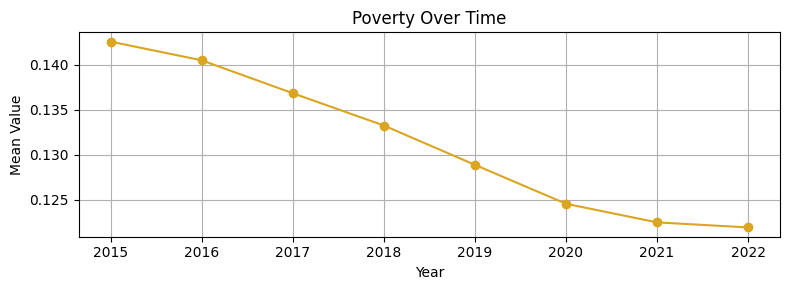

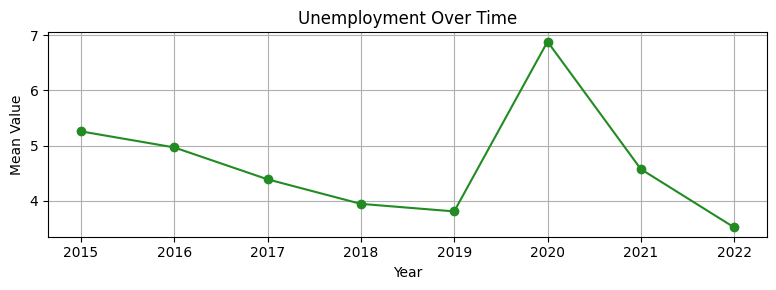

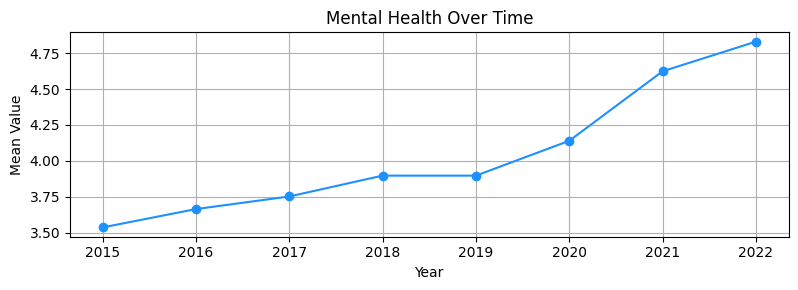

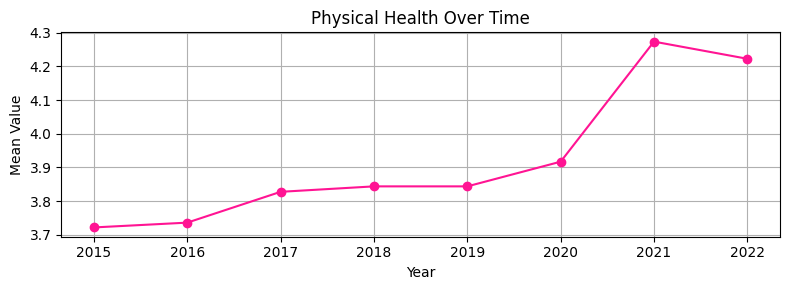

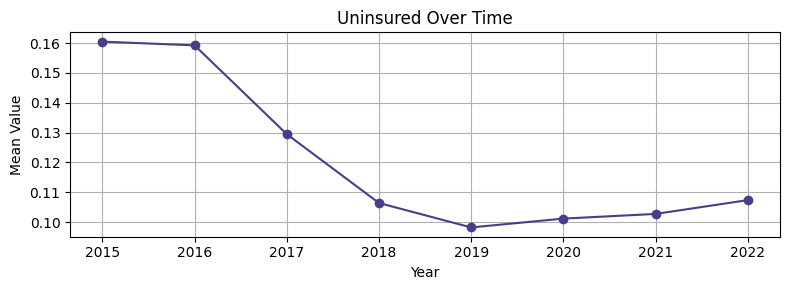

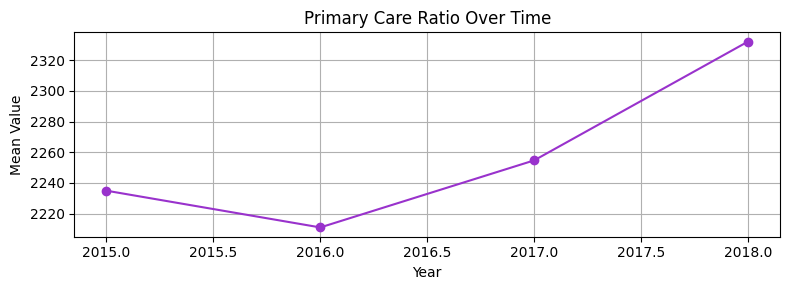

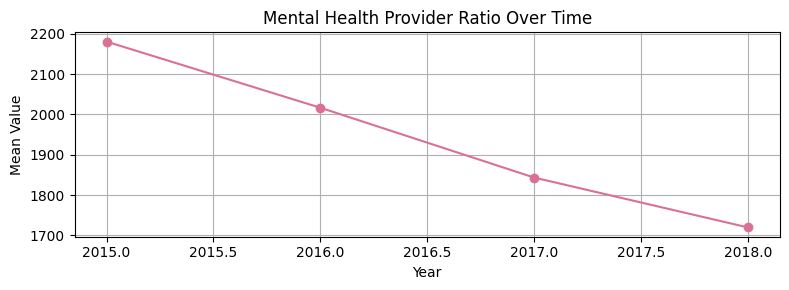

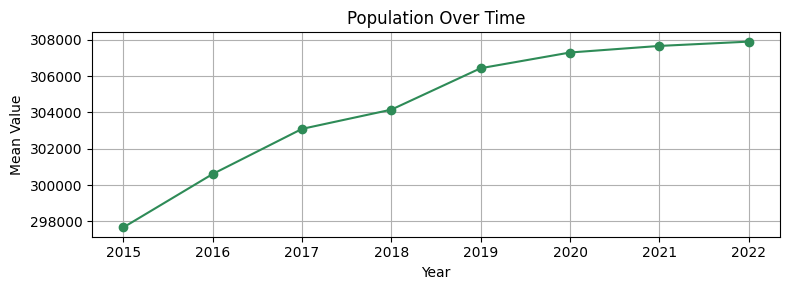

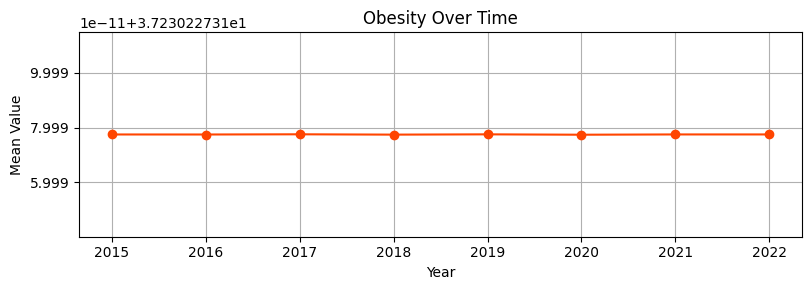

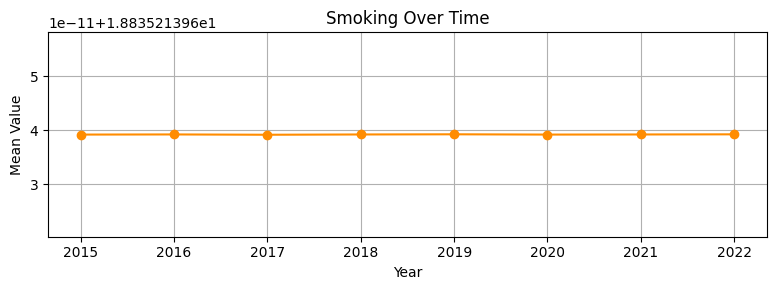

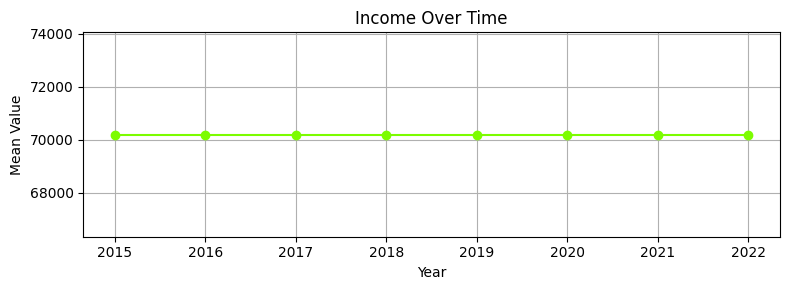

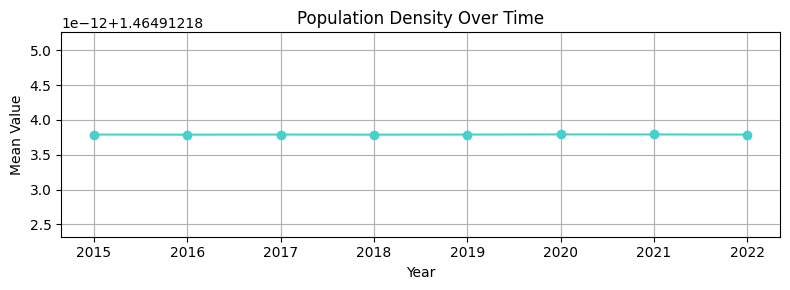

In [203]:
# plot individual trends
for col in df_summaries.columns:
    if col == 'year':
        continue
    plt.figure(figsize=(8,3))
    plt.plot(df_summaries['year'], df_summaries[col], marker='o', color=color_map.get(col, 'black'))
    plt.title(f"{col.replace('mean_', '').replace('_', ' ').title()} Over Time")
    plt.xlabel('Year')
    plt.ylabel('Mean Value')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

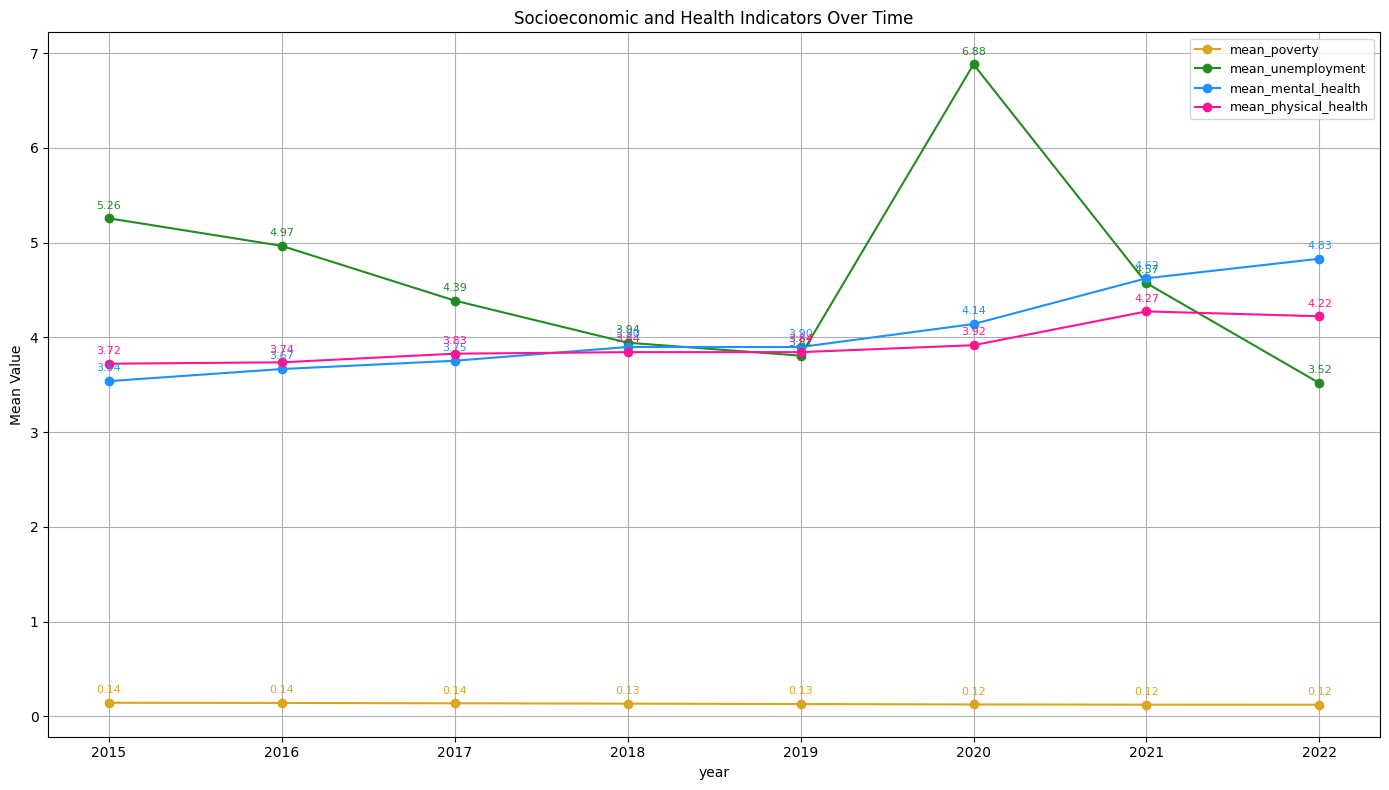

In [204]:
# plot trends over time -- poverty & unemployment vs. mental & physical health
plot_cols = [
    'mean_poverty',
    'mean_unemployment',
    'mean_mental_health',
    'mean_physical_health',
]
plot_cols = [col for col in plot_cols if col in df_summaries.columns]
colors = [color_map[col] for col in plot_cols]

ax = df_summaries.plot(x='year', y=plot_cols, marker='o', figsize=(14, 8), color=colors)

for col in plot_cols:
    for i, row in df_summaries.iterrows():
        ax.annotate(f"{row[col]:.2f}", (row['year'], row[col]), textcoords="offset points", xytext=(0,7), ha='center', fontsize=8, color=color_map[col])

plt.title('Socioeconomic and Health Indicators Over Time')
plt.ylabel('Mean Value')
plt.grid(True)
plt.legend(loc='best', fontsize=9)
plt.tight_layout()
plt.show()

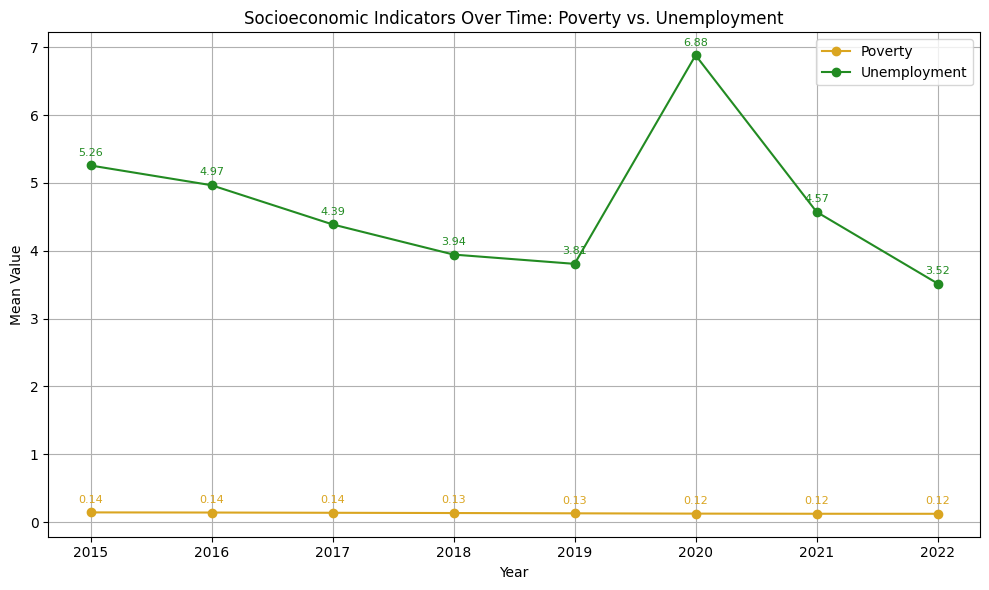

In [205]:
# plot trends over time -- socioeconomic trends
plt.figure(figsize=(10,6))
for col in ['mean_poverty', 'mean_unemployment']:
    plt.plot(df_summaries['year'], df_summaries[col], marker='o', label=col.replace('mean_', '').replace('_', ' ').title(), color=color_map[col])

for col in ['mean_poverty', 'mean_unemployment']:
    for i, row in df_summaries.iterrows():
        plt.annotate(f"{row[col]:.2f}", (row['year'], row[col]), textcoords="offset points", xytext=(0,7), ha='center', fontsize=8, color=color_map[col])

plt.title('Socioeconomic Indicators Over Time: Poverty vs. Unemployment')
plt.xlabel('Year')
plt.ylabel('Mean Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

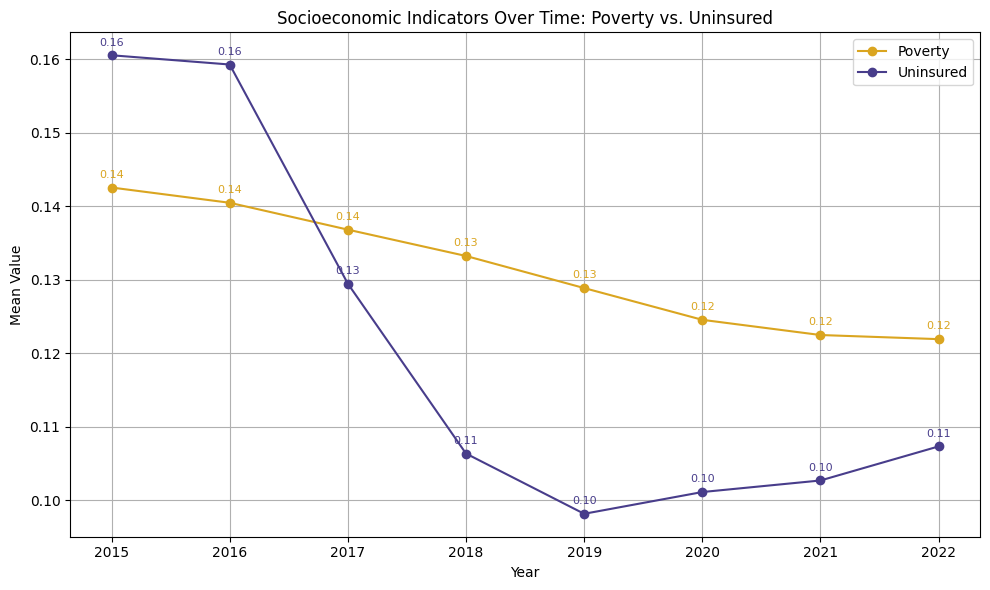

In [206]:
# plot trends over time -- socioeconomic trends
plt.figure(figsize=(10,6))
for col in ['mean_poverty', 'mean_uninsured']:
    plt.plot(df_summaries['year'], df_summaries[col], marker='o', label=col.replace('mean_', '').replace('_', ' ').title(), color=color_map[col])

for col in ['mean_poverty', 'mean_uninsured']:
    for i, row in df_summaries.iterrows():
        plt.annotate(f"{row[col]:.2f}", (row['year'], row[col]), textcoords="offset points", xytext=(0,7), ha='center', fontsize=8, color=color_map[col])

plt.title('Socioeconomic Indicators Over Time: Poverty vs. Uninsured')
plt.xlabel('Year')
plt.ylabel('Mean Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

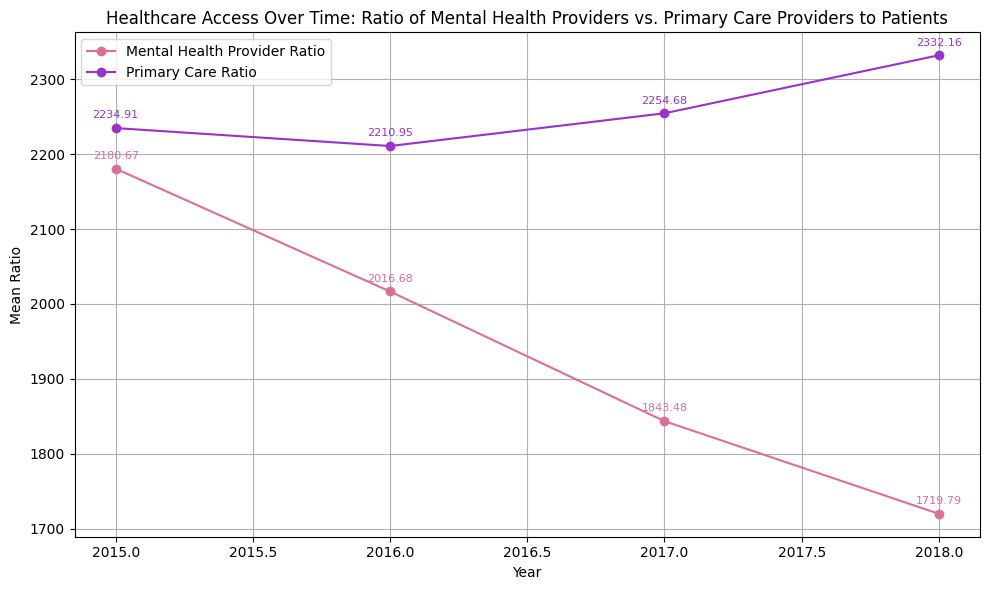

In [207]:
# plot trends over time -- healthcare access trends
plt.figure(figsize=(10,6))
for col in ['mean_mental_health_provider_ratio', 'mean_primary_care_ratio']:
    plt.plot(df_summaries['year'], df_summaries[col], marker='o', label=col.replace('mean_', '').replace('_', ' ').title(), color=color_map[col])

for col in ['mean_mental_health_provider_ratio', 'mean_primary_care_ratio']:
    for i, row in df_summaries.iterrows():
        plt.annotate(f"{row[col]:.2f}", (row['year'], row[col]), textcoords="offset points", xytext=(0,7), ha='center', fontsize=8, color=color_map[col])

plt.title('Healthcare Access Over Time: Ratio of Mental Health Providers vs. Primary Care Providers to Patients')
plt.xlabel('Year')
plt.ylabel('Mean Ratio')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

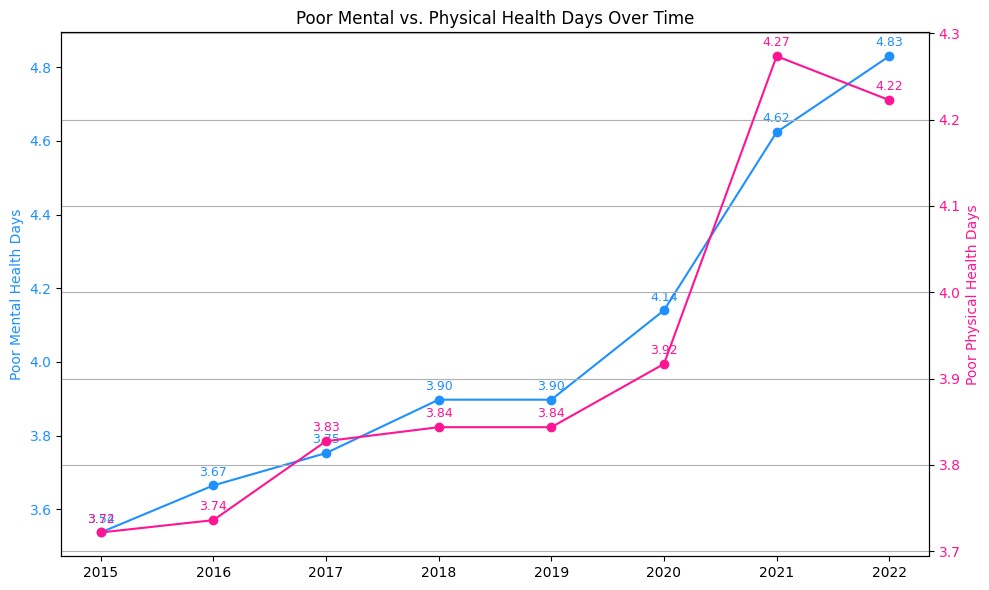

In [208]:
# twinx/dual y-axis plots -- mental & physical health
fig, ax1 = plt.subplots(figsize=(10,6))

# Plot mean mental health days on the left y-axis
ax1.plot(df_summaries['year'], df_summaries['mean_mental_health'], marker='o', color='dodgerblue', label='Poor Mental Health Days')
ax1.set_ylabel('Poor Mental Health Days', color='dodgerblue')
ax1.tick_params(axis='y', labelcolor='dodgerblue')
for i, row in df_summaries.iterrows():
    ax1.annotate(f"{row['mean_mental_health']:.2f}", (row['year'], row['mean_mental_health']),
                 textcoords="offset points", xytext=(0,7), ha='center', fontsize=9, color='dodgerblue')

# Plot mean physical health days on the right y-axis
ax2 = ax1.twinx()
ax2.plot(df_summaries['year'], df_summaries['mean_physical_health'], marker='o', color='deeppink', label='Poor Physical Health Days')
ax2.set_ylabel('Poor Physical Health Days', color='deeppink')
ax2.tick_params(axis='y', labelcolor='deeppink')
for i, row in df_summaries.iterrows():
    ax2.annotate(f"{row['mean_physical_health']:.2f}", (row['year'], row['mean_physical_health']),
                 textcoords="offset points", xytext=(0,7), ha='center', fontsize=9, color='deeppink')

plt.title('Poor Mental vs. Physical Health Days Over Time')
plt.grid(True)
fig.tight_layout()
plt.show()

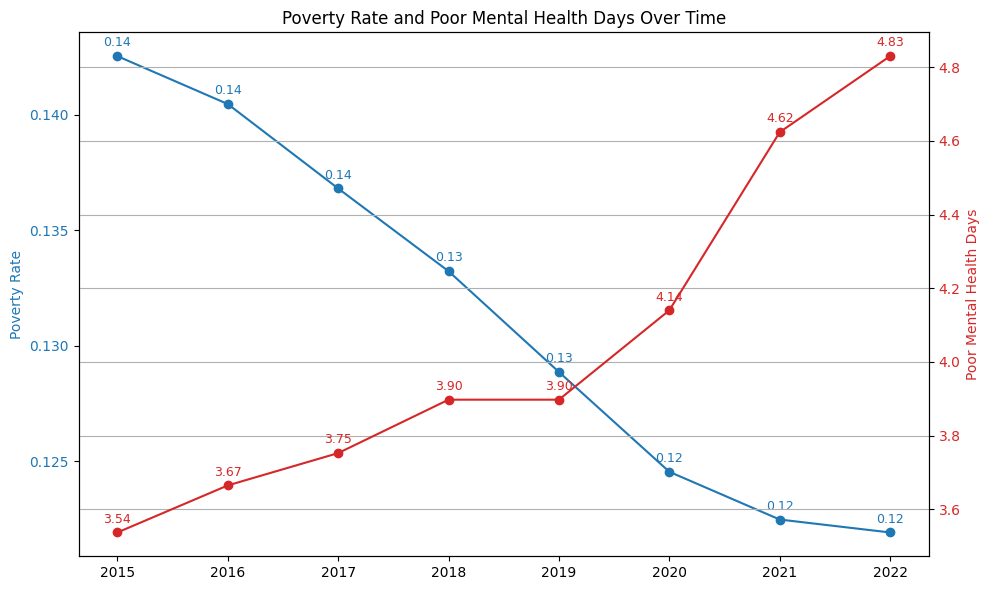

In [209]:
# twinx/dual y-axis plots -- poverty & mental health
fig, ax1 = plt.subplots(figsize=(10,6))

ax1.plot(df_summaries['year'], df_summaries['mean_poverty'], marker='o', color='tab:blue', label='Poverty Rate')
ax1.set_ylabel('Poverty Rate', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
for i, row in df_summaries.iterrows():
    ax1.annotate(f"{row['mean_poverty']:.2f}", (row['year'], row['mean_poverty']),
                 textcoords="offset points", xytext=(0,7), ha='center', fontsize=9, color='tab:blue')

ax2 = ax1.twinx()
ax2.plot(df_summaries['year'], df_summaries['mean_mental_health'], marker='o', color='tab:red', label='Poor Mental Health Days')
ax2.set_ylabel('Poor Mental Health Days', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')
for i, row in df_summaries.iterrows():
    ax2.annotate(f"{row['mean_mental_health']:.2f}", (row['year'], row['mean_mental_health']),
                 textcoords="offset points", xytext=(0,7), ha='center', fontsize=9, color='tab:red')

plt.title('Poverty Rate and Poor Mental Health Days Over Time')
plt.grid(True)
fig.tight_layout()
plt.show()


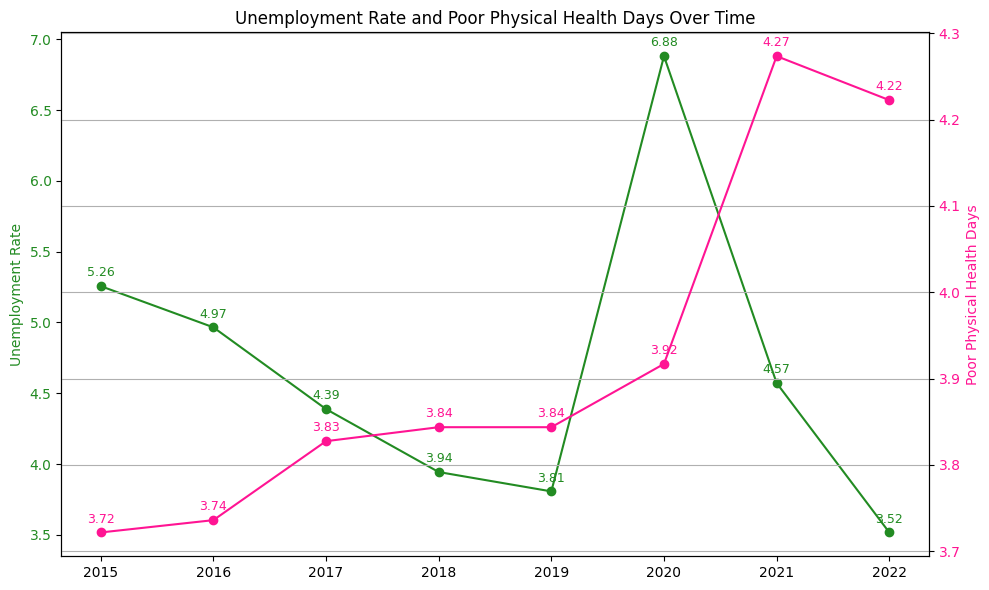

In [210]:
# twinx/dual y-axis plots -- unemployment & physical health
fig, ax1 = plt.subplots(figsize=(10,6))

ax1.plot(df_summaries['year'], df_summaries['mean_unemployment'], marker='o', color='forestgreen', label='Unemployment Rate')
ax1.set_ylabel('Unemployment Rate', color='forestgreen')
ax1.tick_params(axis='y', labelcolor='forestgreen')
for i, row in df_summaries.iterrows():
    ax1.annotate(f"{row['mean_unemployment']:.2f}", (row['year'], row['mean_unemployment']),
                 textcoords="offset points", xytext=(0,7), ha='center', fontsize=9, color='forestgreen')

ax2 = ax1.twinx()
ax2.plot(df_summaries['year'], df_summaries['mean_physical_health'], marker='o', color='deeppink', label='Poor Physical Health Days')
ax2.set_ylabel('Poor Physical Health Days', color='deeppink')
ax2.tick_params(axis='y', labelcolor='deeppink')
for i, row in df_summaries.iterrows():
    ax2.annotate(f"{row['mean_physical_health']:.2f}", (row['year'], row['mean_physical_health']),
                 textcoords="offset points", xytext=(0,7), ha='center', fontsize=9, color='deeppink')

plt.title('Unemployment Rate and Poor Physical Health Days Over Time')
plt.grid(True)
fig.tight_layout()
plt.show()


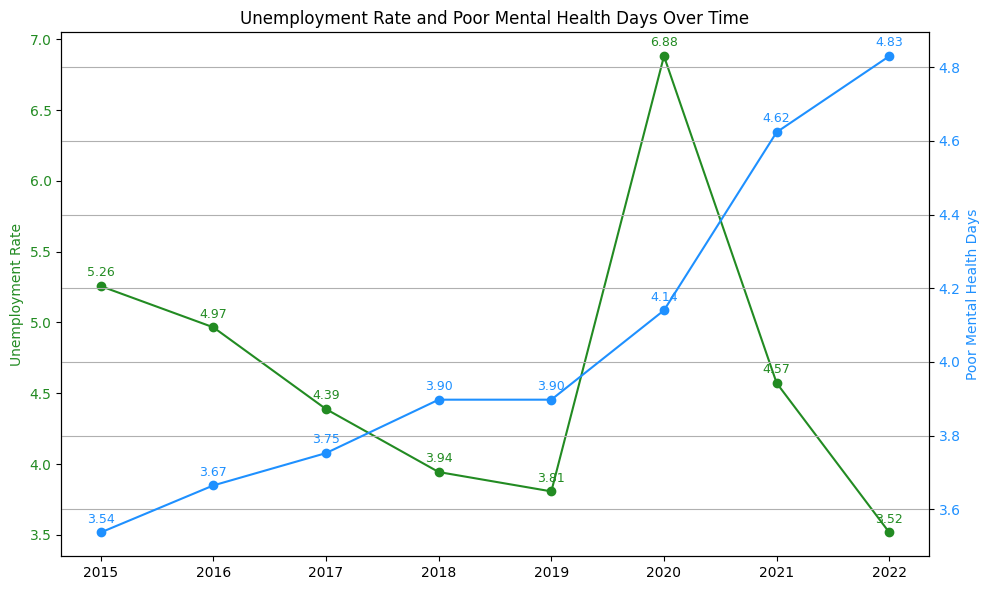

In [211]:
# twinx/dual y-axis plots -- unemployment & mental health
fig, ax1 = plt.subplots(figsize=(10,6))

ax1.plot(df_summaries['year'], df_summaries['mean_unemployment'], marker='o', color='forestgreen', label='Unemployment Rate')
ax1.set_ylabel('Unemployment Rate', color='forestgreen')
ax1.tick_params(axis='y', labelcolor='forestgreen')
for i, row in df_summaries.iterrows():
    ax1.annotate(f"{row['mean_unemployment']:.2f}", (row['year'], row['mean_unemployment']),
                 textcoords="offset points", xytext=(0,7), ha='center', fontsize=9, color='forestgreen')

ax2 = ax1.twinx()
ax2.plot(df_summaries['year'], df_summaries['mean_mental_health'], marker='o', color='dodgerblue', label='Poor Mental Health Days')
ax2.set_ylabel('Poor Mental Health Days', color='dodgerblue')
ax2.tick_params(axis='y', labelcolor='dodgerblue')
for i, row in df_summaries.iterrows():
    ax2.annotate(f"{row['mean_mental_health']:.2f}", (row['year'], row['mean_mental_health']),
                 textcoords="offset points", xytext=(0,7), ha='center', fontsize=9, color='dodgerblue')

plt.title('Unemployment Rate and Poor Mental Health Days Over Time')
plt.grid(True)
fig.tight_layout()
plt.show()


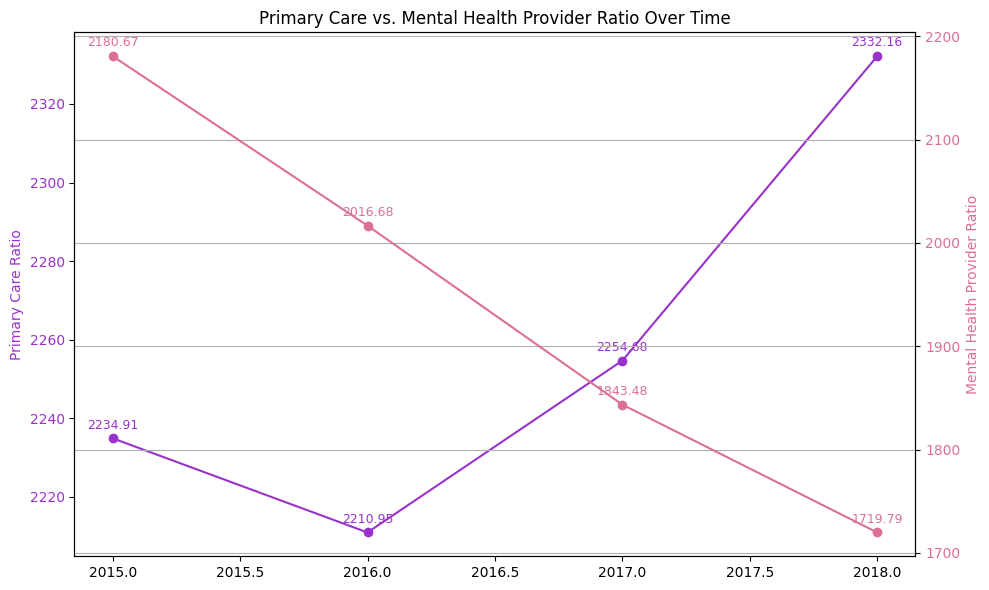

In [212]:
# twinx -- primary care vs. mental health provider ratio over time
fig, ax1 = plt.subplots(figsize=(10,6))

ax1.plot(df_summaries['year'], df_summaries['mean_primary_care_ratio'], marker='o', color='darkorchid', label='Primary Care Ratio')
ax1.set_ylabel('Primary Care Ratio', color='darkorchid')
ax1.tick_params(axis='y', labelcolor='darkorchid')
for i, row in df_summaries.iterrows():
    ax1.annotate(f"{row['mean_primary_care_ratio']:.2f}", (row['year'], row['mean_primary_care_ratio']),
                 textcoords="offset points", xytext=(0,7), ha='center', fontsize=9, color='darkorchid')

ax2 = ax1.twinx()
ax2.plot(df_summaries['year'], df_summaries['mean_mental_health_provider_ratio'], marker='o', color='palevioletred', label='Mental Health Provider Ratio')
ax2.set_ylabel('Mental Health Provider Ratio', color='palevioletred')
ax2.tick_params(axis='y', labelcolor='palevioletred')
for i, row in df_summaries.iterrows():
    ax2.annotate(f"{row['mean_mental_health_provider_ratio']:.2f}", (row['year'], row['mean_mental_health_provider_ratio']),
                 textcoords="offset points", xytext=(0,7), ha='center', fontsize=9, color='palevioletred')

plt.title('Primary Care vs. Mental Health Provider Ratio Over Time')
plt.grid(True)
fig.tight_layout()
plt.show()

In [237]:
# get state from FIPS code
if 'state_name' not in df_plot.columns:
    fips_to_state = {
        '01': 'Alabama', '02': 'Alaska', '04': 'Arizona', '05': 'Arkansas', '06': 'California', '08': 'Colorado', '09': 'Connecticut', '10': 'Delaware',
        '11': 'District of Columbia', '12': 'Florida', '13': 'Georgia', '15': 'Hawaii', '16': 'Idaho', '17': 'Illinois', '18': 'Indiana', '19': 'Iowa',
        '20': 'Kansas', '21': 'Kentucky', '22': 'Louisiana', '23': 'Maine', '24': 'Maryland', '25': 'Massachusetts', '26': 'Michigan', '27': 'Minnesota',
        '28': 'Mississippi', '29': 'Missouri', '30': 'Montana', '31': 'Nebraska','32': 'Nevada', '33': 'New Hampshire', '34': 'New Jersey',
        '35': 'New Mexico', '36': 'New York', '37': 'North Carolina', '38': 'North Dakota', '39': 'Ohio', '40': 'Oklahoma', '41': 'Oregon',
        '42': 'Pennsylvania', '44': 'Rhode Island', '45': 'South Carolina', '46': 'South Dakota', '47': 'Tennessee', '48': 'Texas', '49': 'Utah',
        '50': 'Vermont', '51': 'Virginia', '53': 'Washington', '54': 'West Virginia', '55': 'Wisconsin', '56': 'Wyoming', '72': 'Puerto Rico',
        '78': 'Virgin Islands'
    }
    df_plot['state_fips'] = df_plot['fips5'].astype(str).str.zfill(5).str[:2]
    df_plot['state_name'] = df_plot['state_fips'].map(fips_to_state)

df_plot.head()

fips5  year  poverty_rate  unemployment_rate  poor_mental_health_days  \
0  25013  2020        0.0810          10.933333                 4.700914   
1  25015  2020        0.1967           7.616667                 3.979466   
2  25015  2020        0.1967           7.616667                 3.979466   
3  25015  2020        0.1967           7.616667                 3.979466   
4  25015  2020        0.1967           7.616667                 3.979466   

   poor_physical_health_days  uninsured  ratio_primary_care_physicians  \
0                   4.263948   0.036305                            NaN   
1                   3.592278   0.027618                            NaN   
2                   3.592278   0.027618                            NaN   
3                   3.592278   0.027618                            NaN   
4                   3.592278   0.027618                            NaN   

   ratio_mental_health_providers  population  Percent_Person_Obesity  \
0                            NaN    470406.0                    44.0   
1                            NaN    161355.0                    24.0   
2                            NaN    161355.0                    24.0   
3                            NaN    161355.0                    24.0   
4                            NaN    161355.0                    24.0   

   Percent_Person_Smoking  Median_Income_Household  population_density_log10  \
0                    22.7                  21288.0                  3.260026   
1                    10.7                  79604.0                  2.724753   
2                    10.7                  79604.0                  2.724753   
3                    10.7                  79604.0                  2.724753   
4                    10.7                  79604.0                  2.724753   

  state_fips     state_name  
0         25  Massachusetts  
1         25  Massachusetts  
2         25  Massachusetts  
3         25  Massachusetts  
4         25  Massachusetts

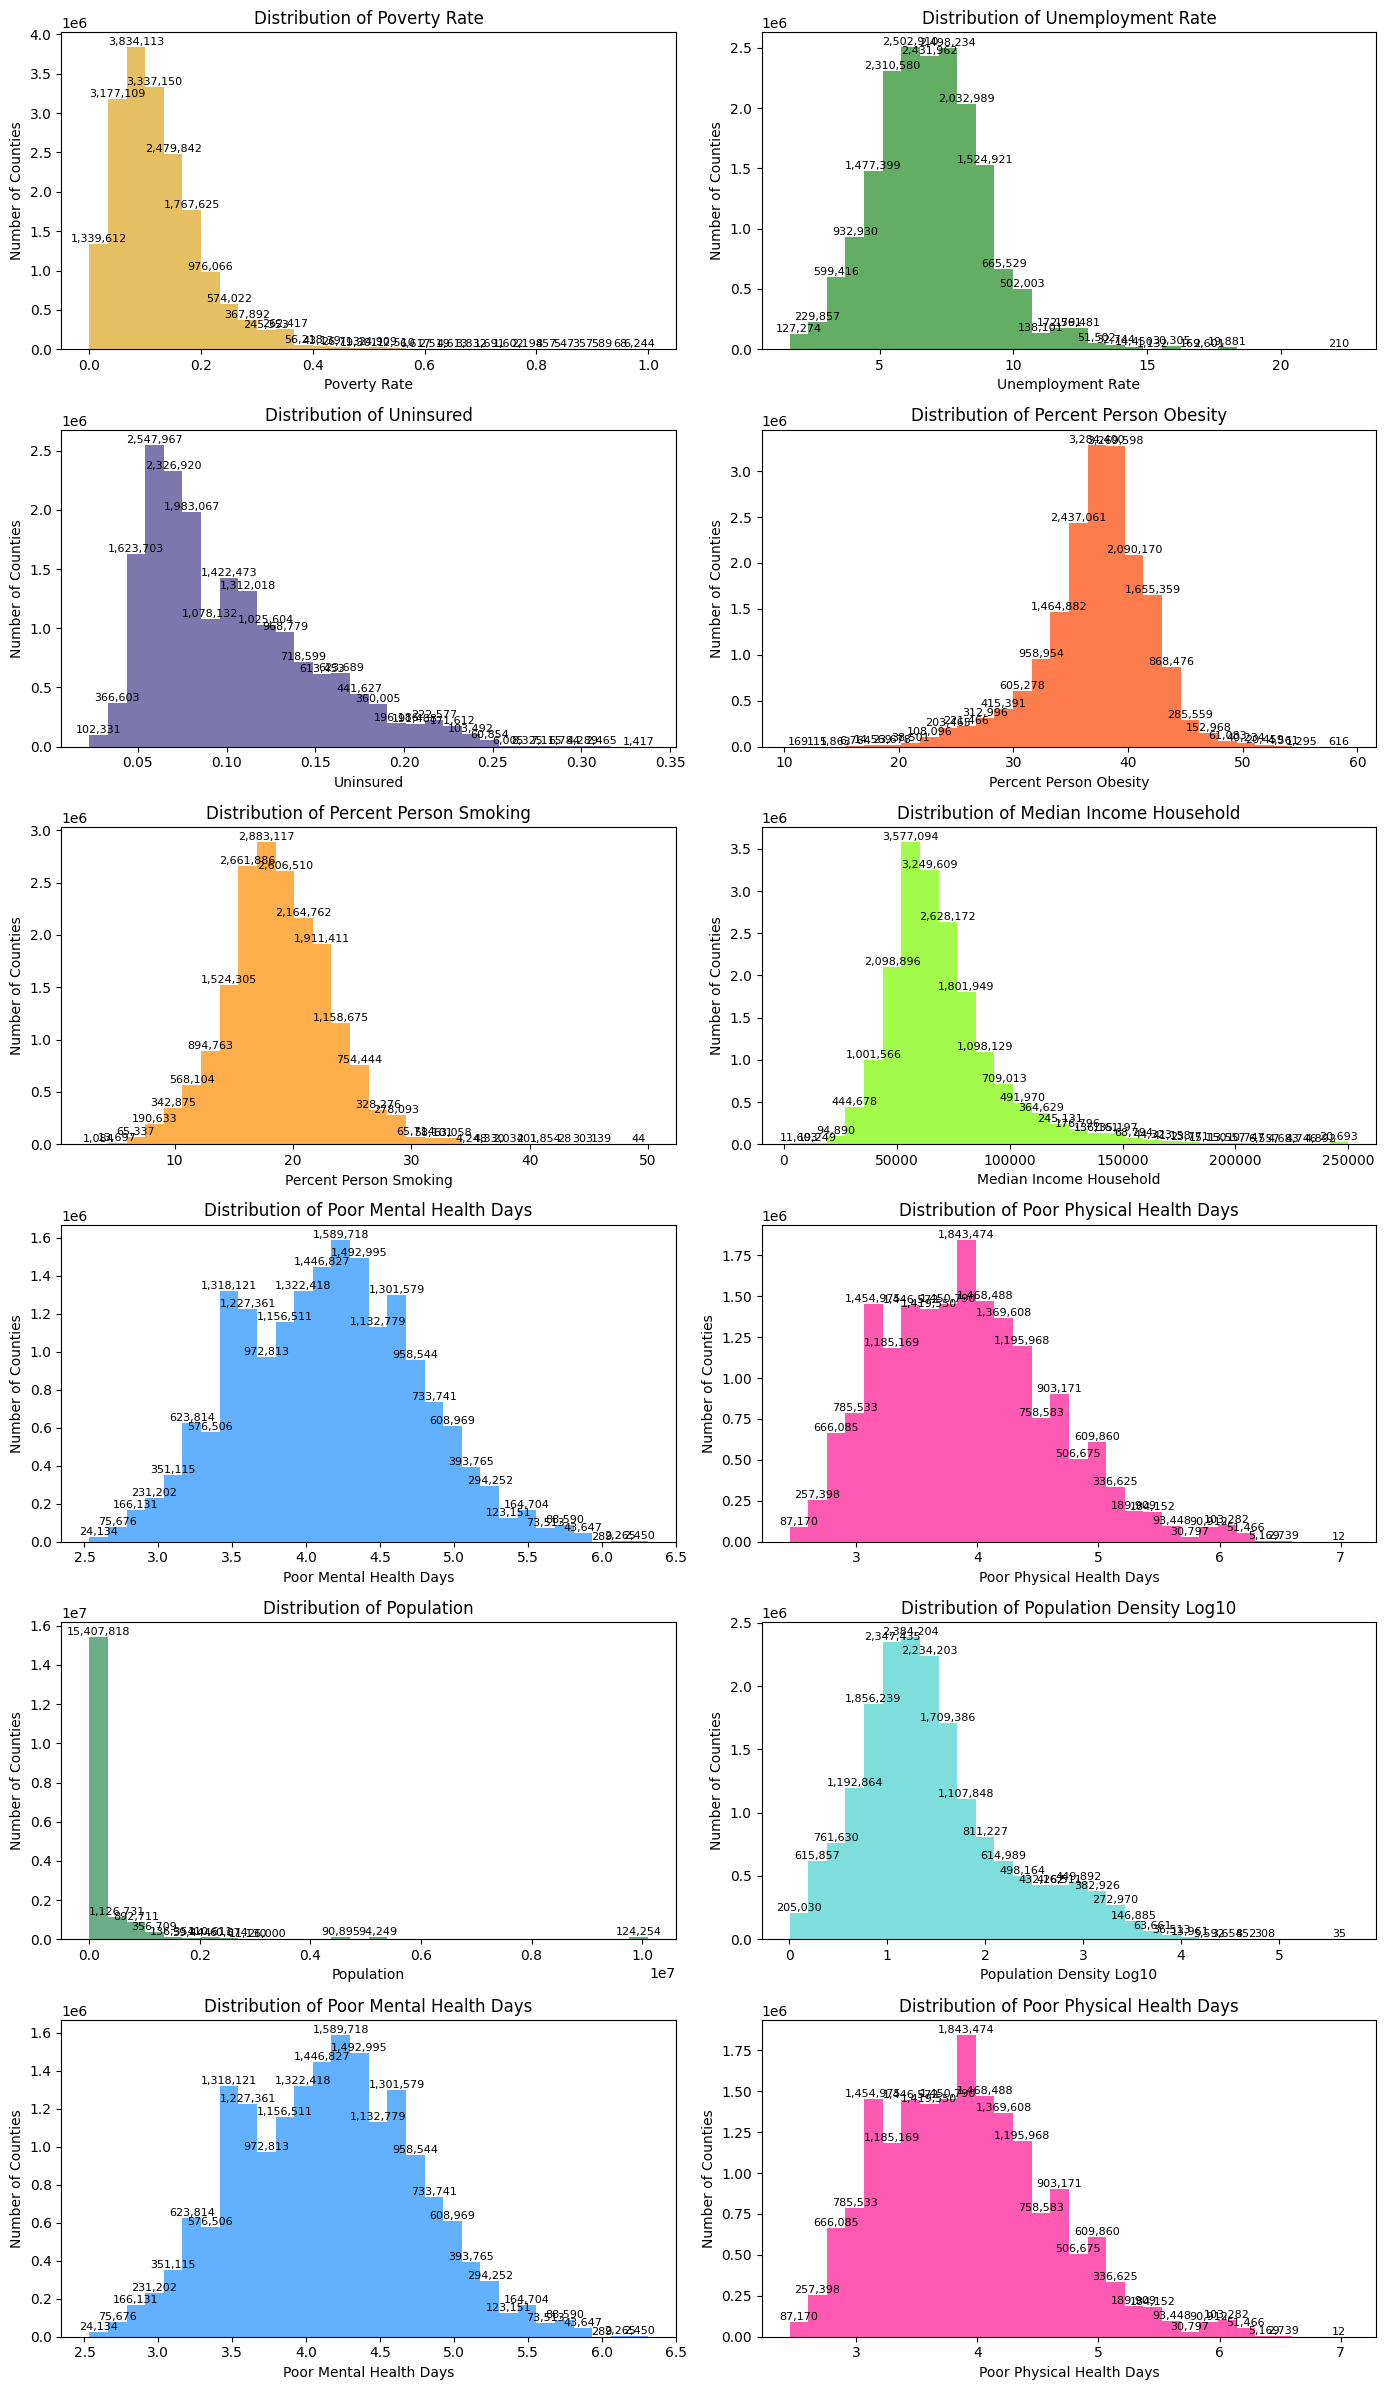

In [255]:
# histograms each feature

feature_to_colormap_key = {
    'poverty_rate': 'mean_poverty',
    'unemployment_rate': 'mean_unemployment',
    'uninsured': 'mean_uninsured',
    'Percent_Person_Obesity': 'mean_obesity',
    'Percent_Person_Smoking': 'mean_smoking',
    'Median_Income_Household': 'mean_income',
    'poor_mental_health_days': 'mean_mental_health',
    'poor_physical_health_days': 'mean_physical_health',
    'population': 'mean_population',
    'population_density_log10': 'mean_population_density'
}
feature_names = list(feature_to_colormap_key.keys())

target_names = ['poor_mental_health_days', 'poor_physical_health_days']
all_vars = feature_names + target_names

n_vars = len(all_vars)
n_cols = 2
n_rows = (n_vars + 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, n_rows * 4))

for idx, var in enumerate(all_vars):
    row = idx // n_cols
    col = idx % n_cols
    ax = axes[row, col]
    if var in feature_to_colormap_key:
        color = color_map[feature_to_colormap_key[var]]
    else:
        color = 'crimson'
    n, bins, patches = ax.hist(df_plot[var].dropna(), bins=30, color=color, alpha=0.7, density=False)
    for i in range(len(patches)):
        if n[i] > 0:
            count_label = f"{int(round(n[i])):,}"
            ax.text(patches[i].get_x() + patches[i].get_width() / 2, n[i], count_label, ha='center', va='bottom', fontsize=8)
    ax.set_title(f'Distribution of {var.replace("_", " ").title()}')
    ax.set_xlabel(var.replace("_", " ").title())
    ax.set_ylabel('Number of Counties')
    
for j in range(idx + 1, n_rows * n_cols):
    fig.delaxes(axes.flatten()[j])

plt.tight_layout()
plt.show()

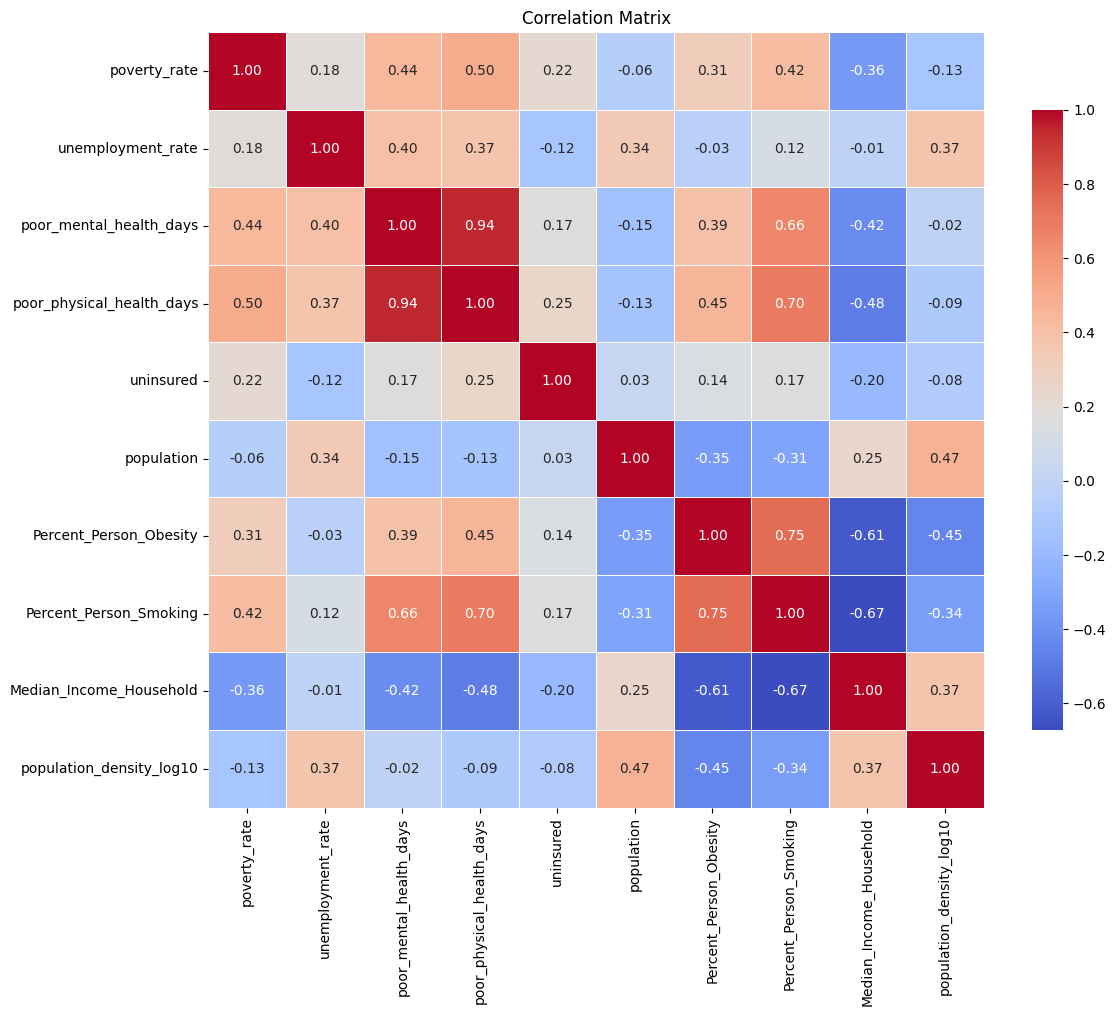

In [239]:
# heatmap correlation
corr_vars = [
    'poverty_rate',
    'unemployment_rate',
    'poor_mental_health_days',
    'poor_physical_health_days',
    'uninsured',
    # 'ratio_primary_care_physicians',   # NaN
    # 'ratio_mental_health_providers',   # NaN
    'population',
    'Percent_Person_Obesity',
    'Percent_Person_Smoking',
    'Median_Income_Household',
    'population_density_log10'
]
corr_vars = [v for v in corr_vars if v in df_plot.columns]

corr = df_plot[corr_vars].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, square=True, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

In [222]:
# interpretation -- correlation matrix (red positive/direct, blue negative/inverse correlations, white/gray little or no linear relationship)
# note: blanks -- missing data, correlation couldn't be computed/found (primary care & mental health physicians)

## STRONG positive relationships
#### poor_mental_health_days && poor_physical_health_days: 0.94 -- poor mental health days also tend to accompany poor physical health days
#### Percent_Person_Smoking && poor_mental_health_days: 0.66 -- higher smoking rates are strongly associated with more poor mental health days
#### Percent_Person_Smoking && poor_physical_health_days: 0.70 -- higher smoking rates are strongly associated with more poor physical health days
#### Percent_Person_Obesity && poor_physical_health_days: 0.45 -- higher obesity is linked to more poor physical health days
#### poverty_rate && poor_physical_health_days: 0.50 --------- higher poverty is associated with more poor physical health days
#### poverty_rate && poor_mental_health_days: 0.44 ----------- higher poverty is associated with more poor mental health days
#### Percent_Person_Obesity && Percent_Person_Smoking: 0.75 --- counties with high obesity rates also strongly tend to have high smoking rates

## STRONG negative relationships
#### Median_Income_Household && poor_mental_health_days: -0.42 -- higher income counties have fewer poor mental health days
#### Median_Income_Household && poor_physical_health_days: -0.48 -- higher income counties have fewer poor physical health days
#### Median_Income_Household && Percent_Person_Smoking: -0.67 -- higher income counties have much lower smoking rates
#### Median_Income_Household && Percent_Person_Obesity: -0.61 -- higher income counties have much lower obesity rates

## OTHER relatinships
#### unemployment_rate has moderate POSITIVE correlations with both poor mental health days (0.40) and poor physical health days (0.37)
#### uninsured has weak POSITIVE correlations with with both poor mental health days (0.17) and poor physical health days (0.25)
#### population_density_log10 (population density; urban or rural) has mostly WEAK correlations with all health measures (all values close to zero)

In [223]:
# Socioeconomic factors (poverty, unemployment, uninsured, income) are strongly linked to both poor mental and physical health at the county level.
# Behavioral risk factors (smoking, obesity) are also strongly linked to poor health outcomes.
# Income acts as a protective factor: higher income is associated with better health and lower rates of smoking/obesity.
# Counties with high poverty and low income tend to have higher rates of poor mental/physical health, smoking, and obesity.
# Population and provider ratios had missing data (shown as "-"), so no conclusions can be drawn there from this matrix.

In [249]:
print(df_plot.columns.tolist())

['fips5', 'year', 'poverty_rate', 'unemployment_rate', 'poor_mental_health_days', 'poor_physical_health_days', 'uninsured', 'ratio_primary_care_physicians', 'ratio_mental_health_providers', 'population', 'Percent_Person_Obesity', 'Percent_Person_Smoking', 'Median_Income_Household', 'population_density_log10', 'state_fips', 'state_name']


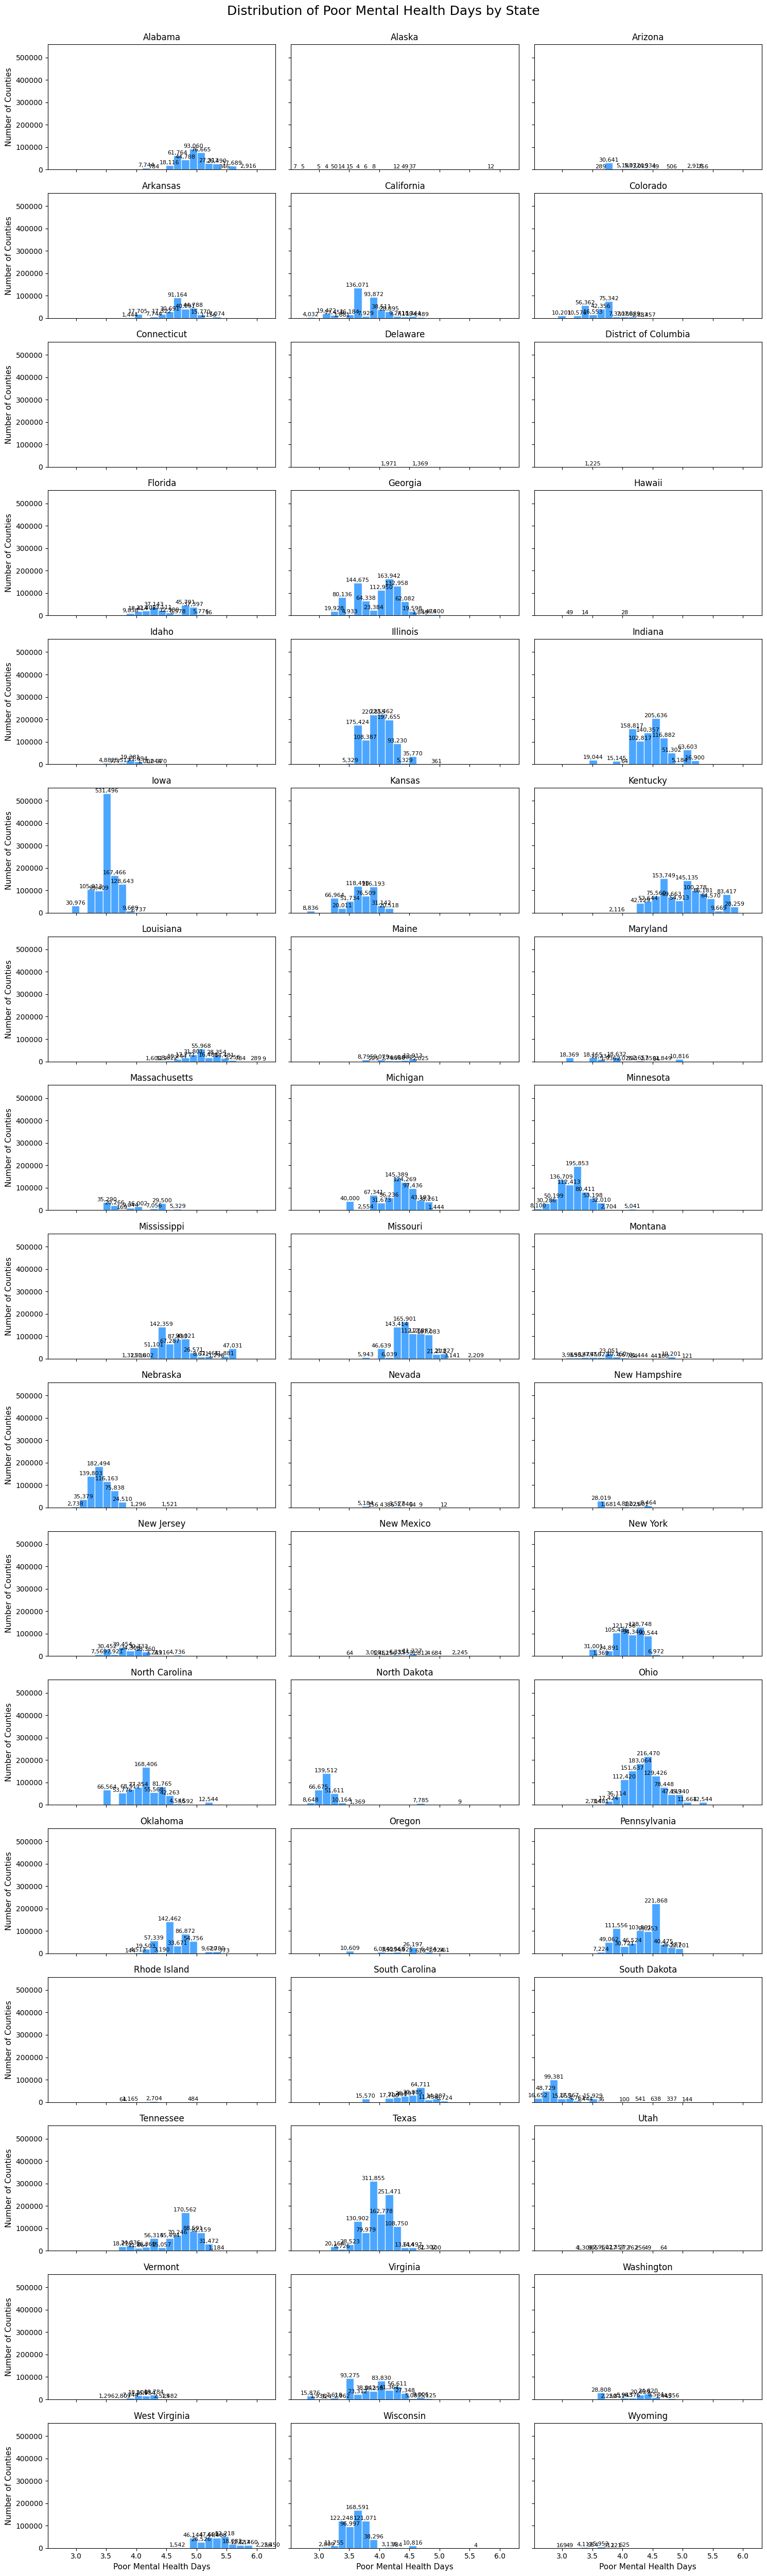

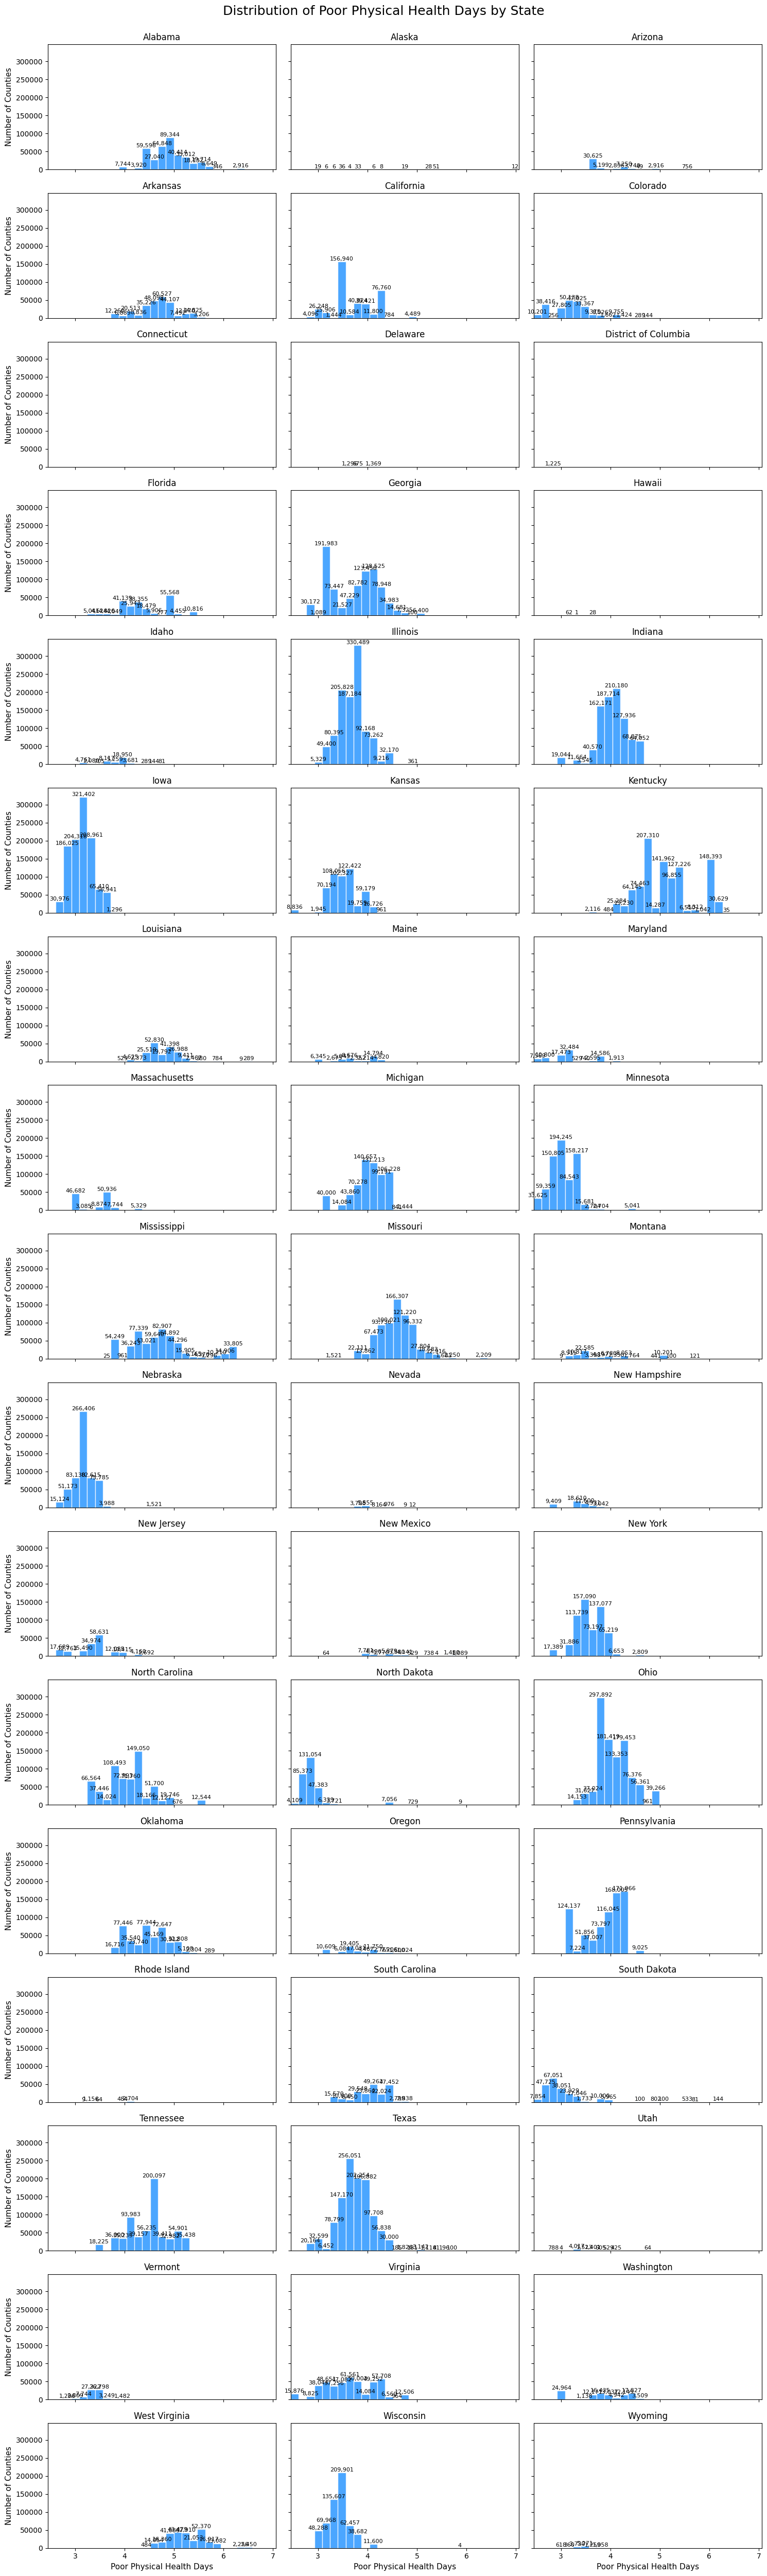

In [253]:
# poor mental health days per state -- variance across counties
targets = ['poor_mental_health_days', 'poor_physical_health_days']
target_titles = ['Poor Mental Health Days', 'Poor Physical Health Days']

states = sorted(df_plot['state_name'].dropna().unique())
n_states = len(states)
n_cols = 3
n_rows = int(np.ceil(n_states / n_cols))

for t_idx, target in enumerate(targets):
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 3), sharex=True, sharey=True)
    axes = axes.flatten()
    
    all_data = df_plot[target].dropna()
    bins = np.linspace(all_data.min(), all_data.max(), 30)

    for idx, state in enumerate(states):
        ax = axes[idx]
        subset = df_plot[df_plot['state_name'] == state][target].dropna()
        n, _, patches = ax.hist(subset, bins=bins, color='dodgerblue', alpha=0.8, edgecolor='white')
        ax.set_title(state, fontsize=12)
        if idx % n_cols == 0:
            ax.set_ylabel('Number of Counties', fontsize=11)
        if idx // n_cols == n_rows - 1:
            ax.set_xlabel(target_titles[t_idx], fontsize=11)
        ax.tick_params(axis='both', which='major', labelsize=10)
        ax.set_xlim(bins[0], bins[-1])
        for i in range(len(patches)):
            if n[i] > 0:
                count_label = f"{int(round(n[i])):,}"
                ax.text(patches[i].get_x() + patches[i].get_width() / 2, n[i], count_label, ha='center', va='bottom', fontsize=8)

    for j in range(idx + 1, len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle(f'Distribution of {target_titles[t_idx]} by State', fontsize=18)
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()

In [254]:
# not very insightful -- suggets uneven participation (voluntary) and response rates per state significantly differ -- also county/population sizes
# 

In [256]:
print(df_plot.columns.tolist())

['fips5', 'year', 'poverty_rate', 'unemployment_rate', 'poor_mental_health_days', 'poor_physical_health_days', 'uninsured', 'ratio_primary_care_physicians', 'ratio_mental_health_providers', 'population', 'Percent_Person_Obesity', 'Percent_Person_Smoking', 'Median_Income_Household', 'population_density_log10', 'state_fips', 'state_name']


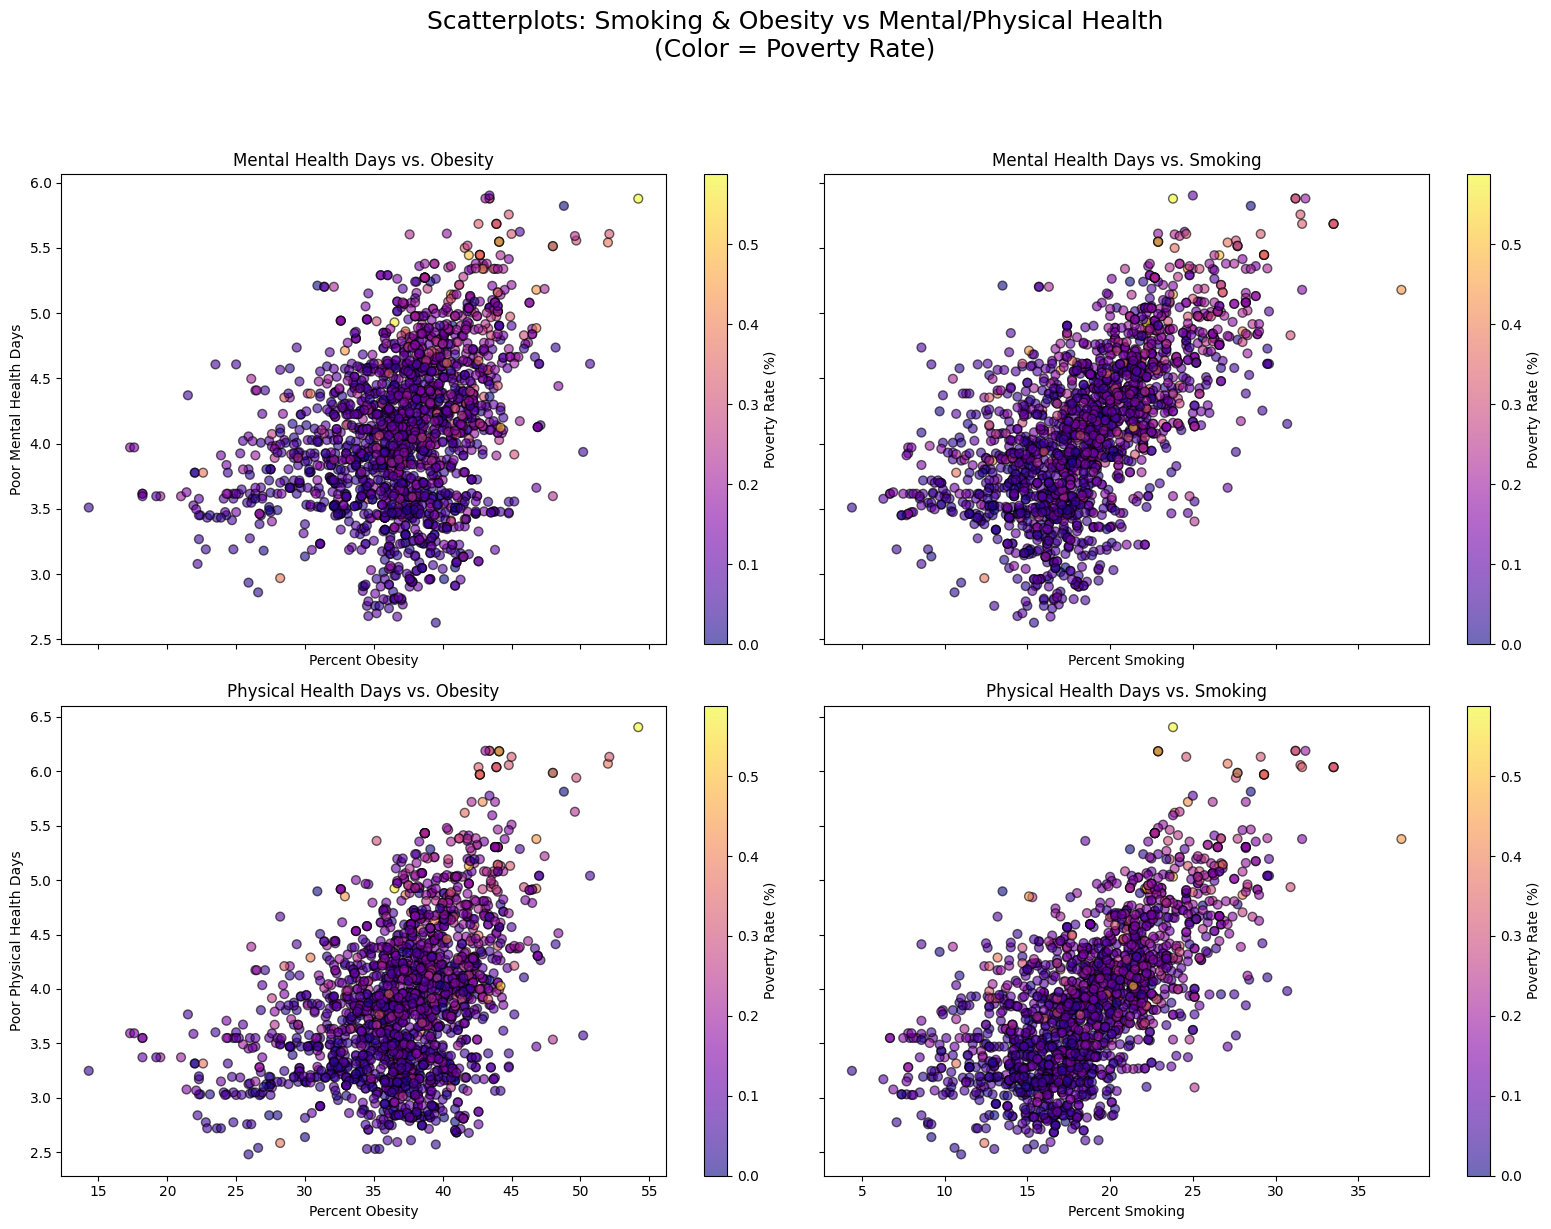

In [261]:
# scatterplot -- poverty rate vs. poor mental health (color = smokinig rate, obesity)
sample_size = 2000
if len(df_plot) > sample_size:
    df_scatter = df_plot.sample(n=sample_size, random_state=42)
else:
    df_scatter = df_plot

fig, axes = plt.subplots(2, 2, figsize=(16, 12), sharex='col', sharey='row')
scatter_settings = dict(alpha=0.6, edgecolor='k', s=40)

# obesity vs poor mental health
sc1 = axes[0, 0].scatter(
    df_scatter['Percent_Person_Obesity'],
    df_scatter['poor_mental_health_days'],
    c=df_scatter['poverty_rate'],
    cmap='plasma',
    **scatter_settings
)
axes[0, 0].set_title('Mental Health Days vs. Obesity')
axes[0, 0].set_ylabel('Poor Mental Health Days')
axes[0, 0].set_xlabel('Percent Obesity')
plt.colorbar(sc1, ax=axes[0, 0], label='Poverty Rate (%)')

# smoking vs poor mental health
sc2 = axes[0, 1].scatter(
    df_scatter['Percent_Person_Smoking'],
    df_scatter['poor_mental_health_days'],
    c=df_scatter['poverty_rate'],
    cmap='plasma',
    **scatter_settings
)
axes[0, 1].set_title('Mental Health Days vs. Smoking')
axes[0, 1].set_xlabel('Percent Smoking')
plt.colorbar(sc2, ax=axes[0, 1], label='Poverty Rate (%)')

# obesity vs poor physical health
sc3 = axes[1, 0].scatter(
    df_scatter['Percent_Person_Obesity'],
    df_scatter['poor_physical_health_days'],
    c=df_scatter['poverty_rate'],
    cmap='plasma',
    **scatter_settings
)
axes[1, 0].set_title('Physical Health Days vs. Obesity')
axes[1, 0].set_ylabel('Poor Physical Health Days')
axes[1, 0].set_xlabel('Percent Obesity')
plt.colorbar(sc3, ax=axes[1, 0], label='Poverty Rate (%)')

# smoking vs poor physical health
sc4 = axes[1, 1].scatter(
    df_scatter['Percent_Person_Smoking'],
    df_scatter['poor_physical_health_days'],
    c=df_scatter['poverty_rate'],
    cmap='plasma',
    **scatter_settings
)
axes[1, 1].set_title('Physical Health Days vs. Smoking')
axes[1, 1].set_xlabel('Percent Smoking')
plt.colorbar(sc4, ax=axes[1, 1], label='Poverty Rate (%)')

plt.suptitle('Scatterplots: Smoking & Obesity vs Mental/Physical Health\n(Color = Poverty Rate)', fontsize=18, y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

plt.clf()
plt.close()

In [284]:
# intepretation -- all years combined

## All plots show a clear POSITIVE relationship
## Most counties are clustered at lower to moderate values for both risk factors and health outcomes, a few outliers are at the high end
## Counties with higher obesity and smoking rates tend to report more poor mental and physical health days
## Counties with higher poverty not only have more obesity/smoking, but also worse health outcomes
## Poverty rate worsens health: counties with higher poverty (yellow) are more likely to have both high risk factors and worse health outcomes
## Interventions targeting obesity, smoking, and poverty could have a significant impact on both mental and physical health at the county level

In [264]:
# Random Forest modeling
# to model and predict complex, nonlinear relationships between health outcomes (e.g., poor mental health days) and socioeconomic/health factors
df_plot.head()

fips5  year  poverty_rate  unemployment_rate  poor_mental_health_days  \
0  25013  2020        0.0810          10.933333                 4.700914   
1  25015  2020        0.1967           7.616667                 3.979466   
2  25015  2020        0.1967           7.616667                 3.979466   
3  25015  2020        0.1967           7.616667                 3.979466   
4  25015  2020        0.1967           7.616667                 3.979466   

   poor_physical_health_days  uninsured  ratio_primary_care_physicians  \
0                   4.263948   0.036305                            NaN   
1                   3.592278   0.027618                            NaN   
2                   3.592278   0.027618                            NaN   
3                   3.592278   0.027618                            NaN   
4                   3.592278   0.027618                            NaN   

   ratio_mental_health_providers  population  Percent_Person_Obesity  \
0                            NaN    470406.0                    44.0   
1                            NaN    161355.0                    24.0   
2                            NaN    161355.0                    24.0   
3                            NaN    161355.0                    24.0   
4                            NaN    161355.0                    24.0   

   Percent_Person_Smoking  Median_Income_Household  population_density_log10  \
0                    22.7                  21288.0                  3.260026   
1                    10.7                  79604.0                  2.724753   
2                    10.7                  79604.0                  2.724753   
3                    10.7                  79604.0                  2.724753   
4                    10.7                  79604.0                  2.724753   

  state_fips     state_name  
0         25  Massachusetts  
1         25  Massachusetts  
2         25  Massachusetts  
3         25  Massachusetts  
4         25  Massachusetts

Processing year: 2015
poor_mental_health_days: RMSE = 0.87, R² = 0.43
poor_physical_health_days: RMSE = 0.83, R² = 0.45


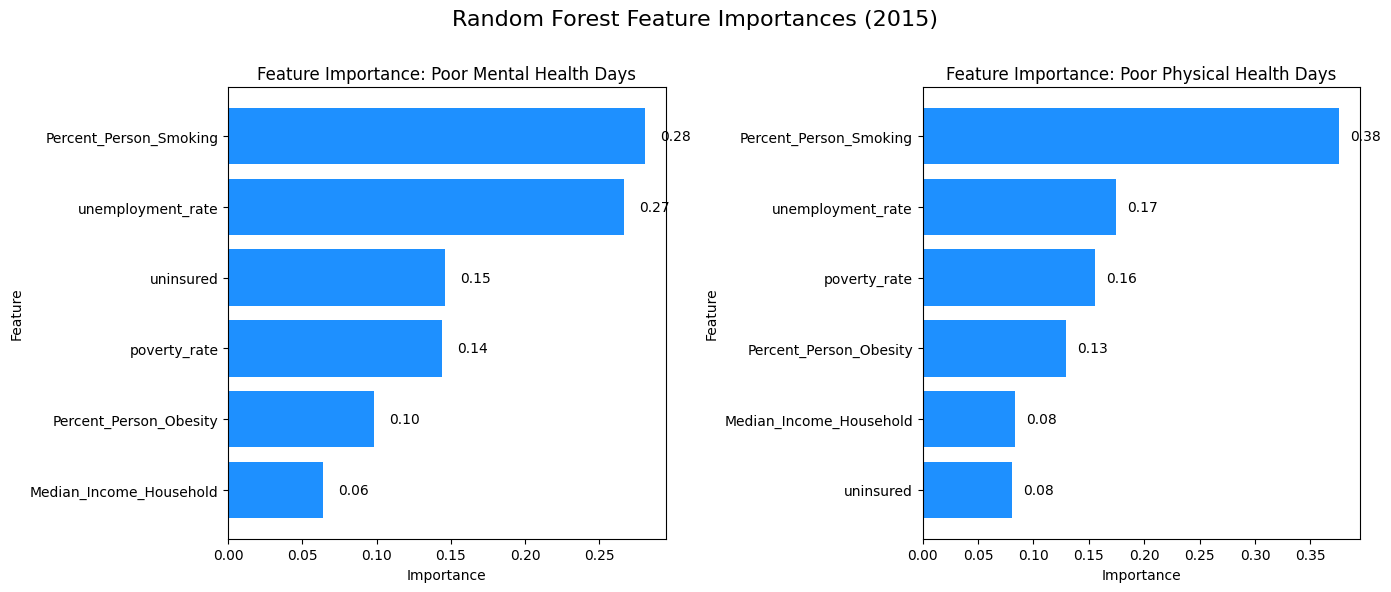

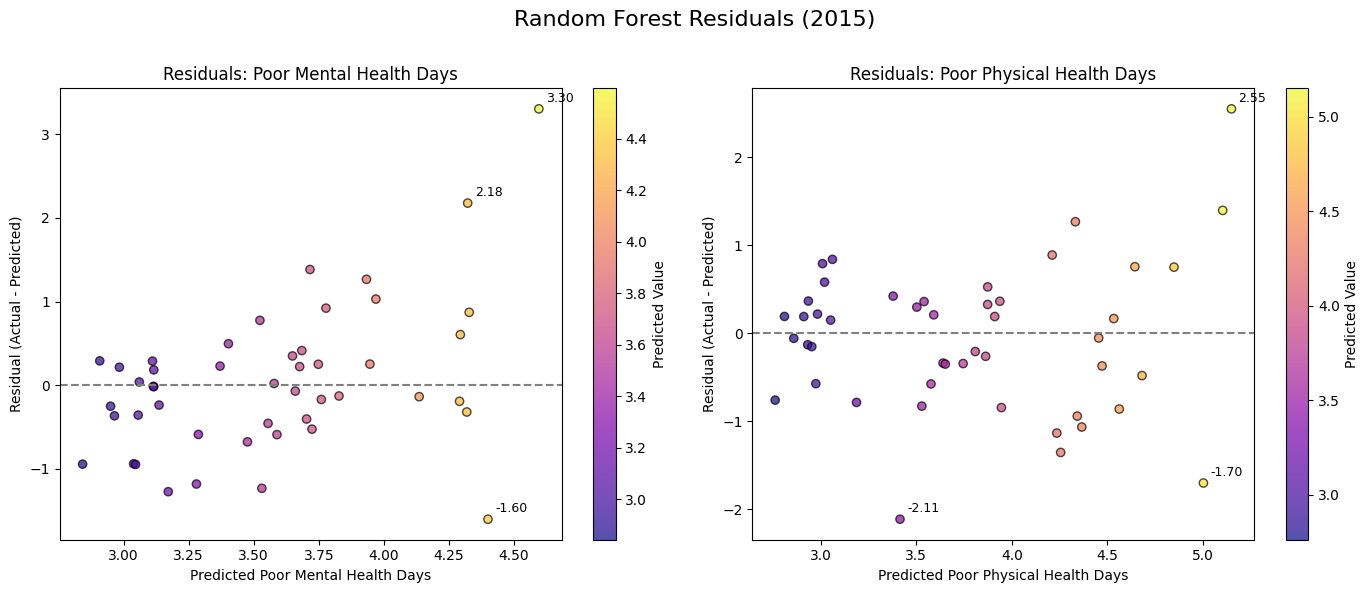

Processing year: 2016
poor_mental_health_days: RMSE = 0.36, R² = 0.60
poor_physical_health_days: RMSE = 0.36, R² = 0.72


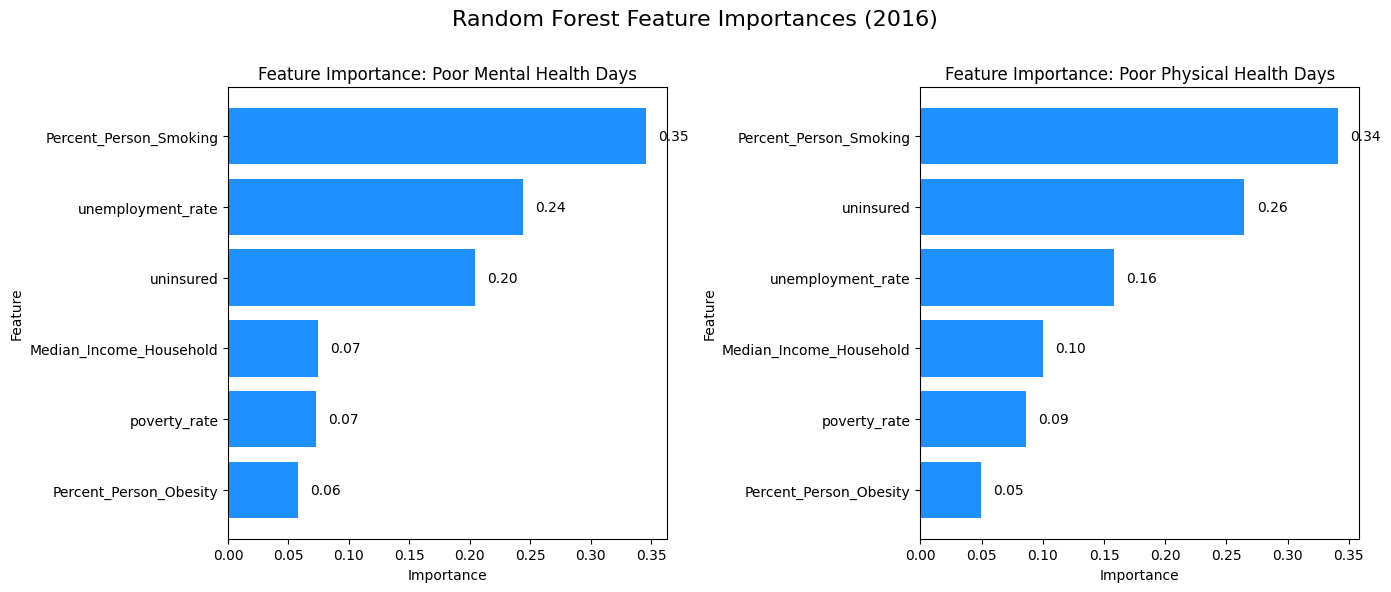

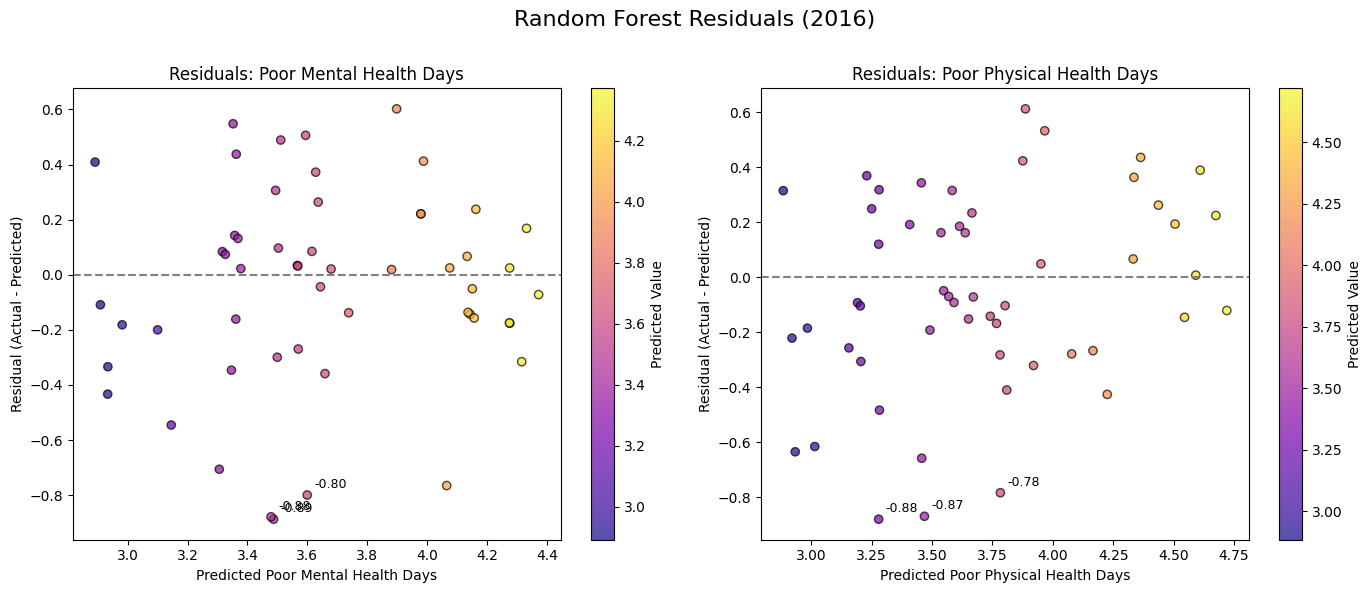

Processing year: 2017
poor_mental_health_days: RMSE = 0.33, R² = 0.52
poor_physical_health_days: RMSE = 0.36, R² = 0.62


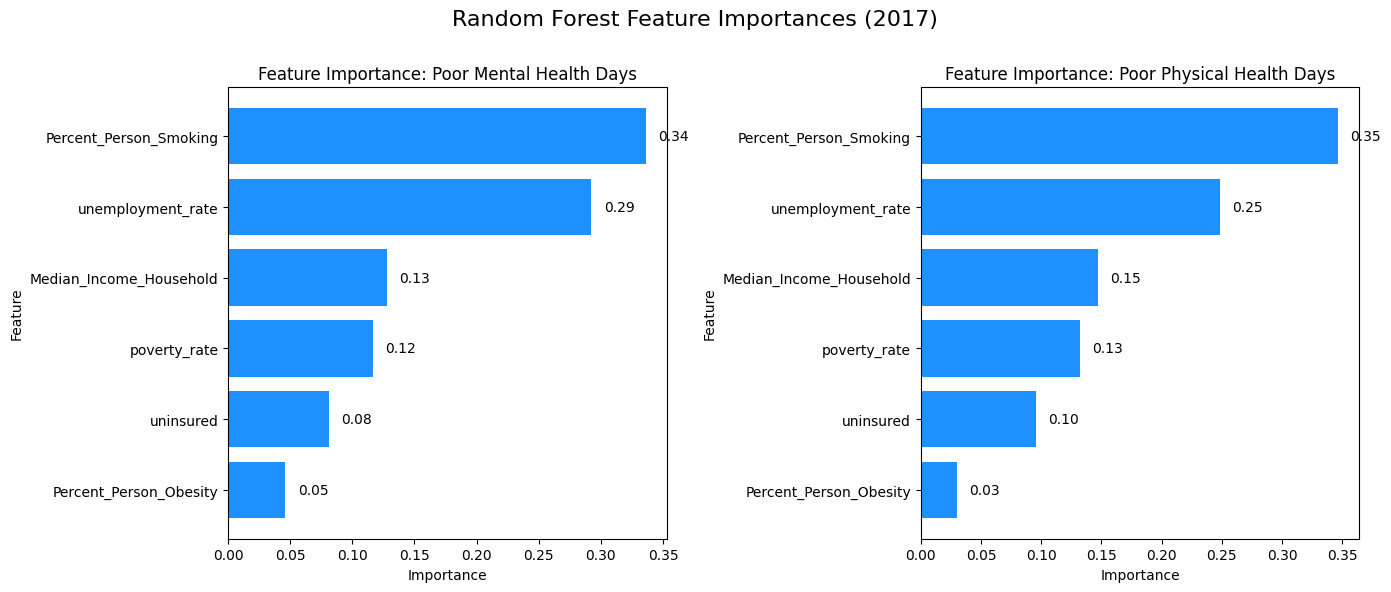

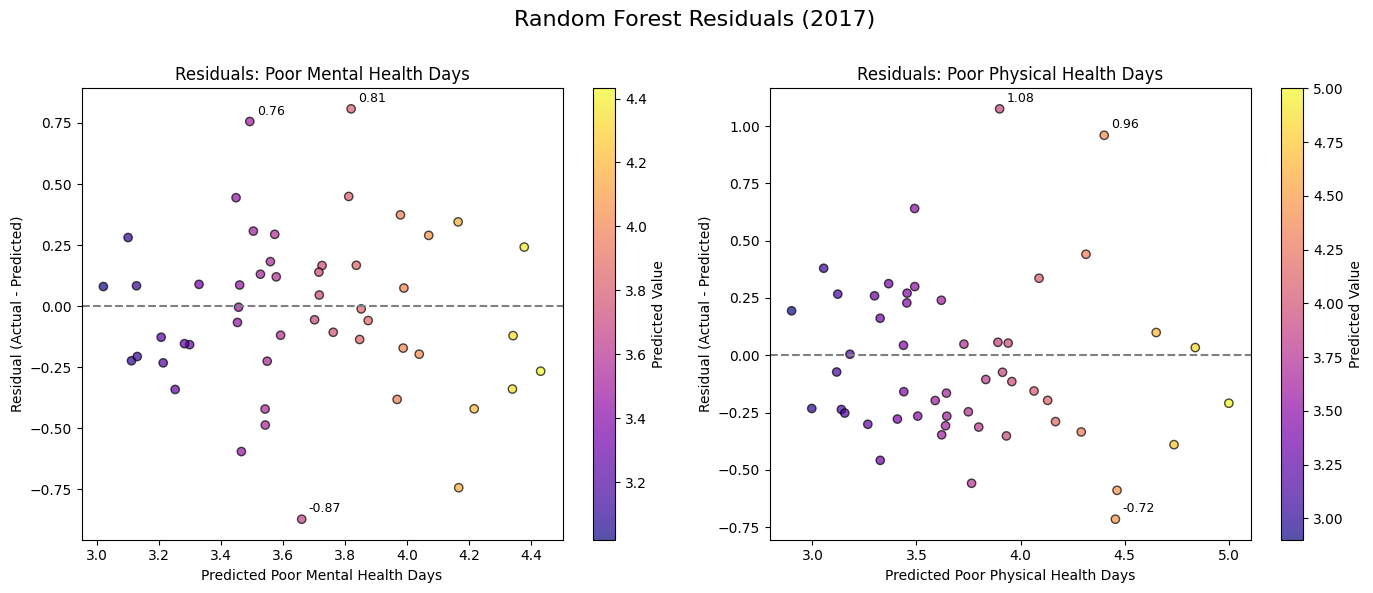

Processing year: 2018
poor_mental_health_days: RMSE = 0.49, R² = 0.53
poor_physical_health_days: RMSE = 0.54, R² = 0.60


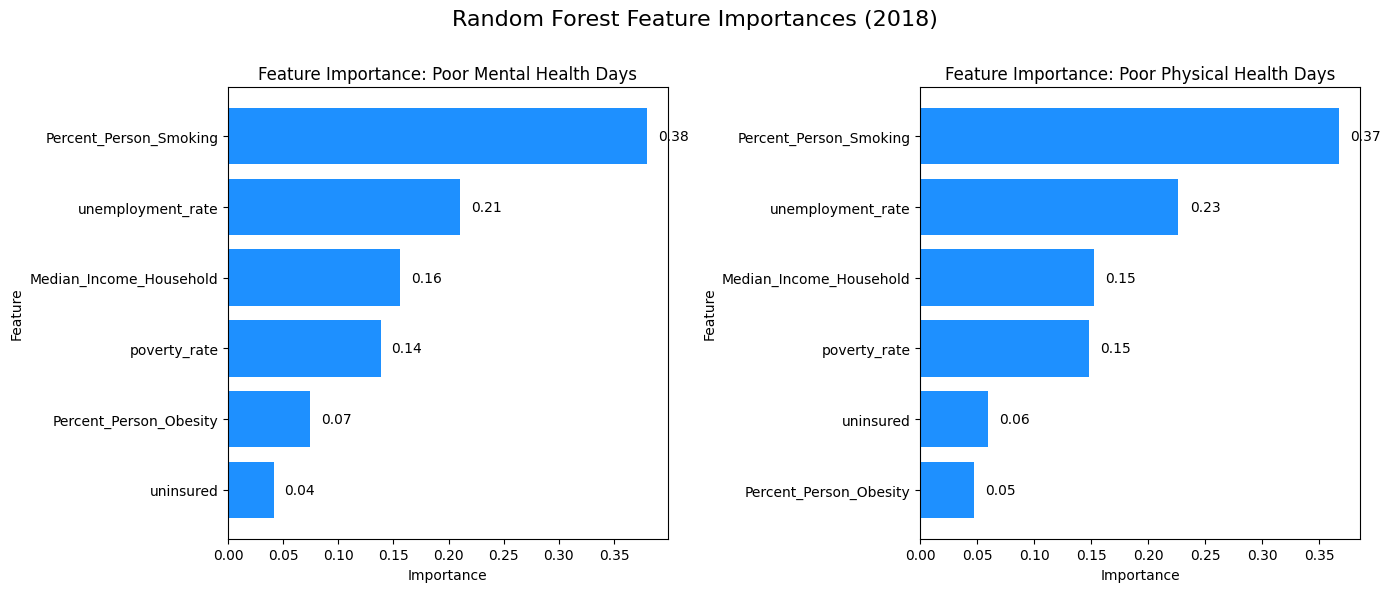

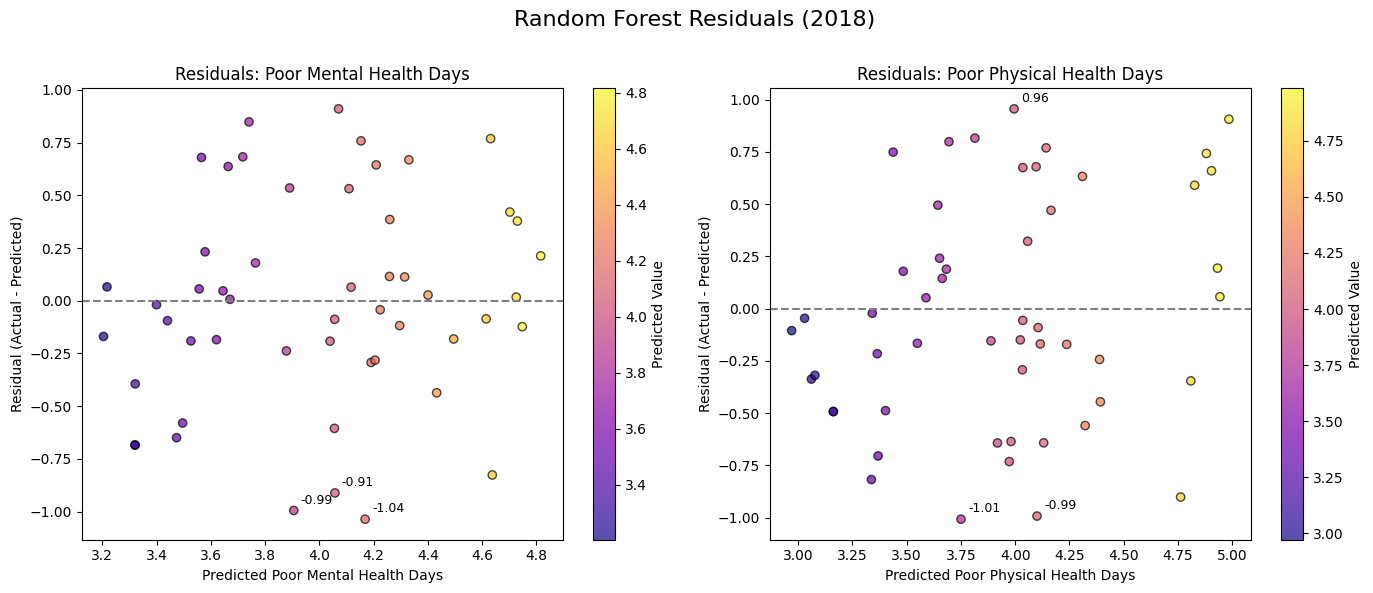

Processing year: 2019
poor_mental_health_days: RMSE = 0.43, R² = 0.49
poor_physical_health_days: RMSE = 0.43, R² = 0.58


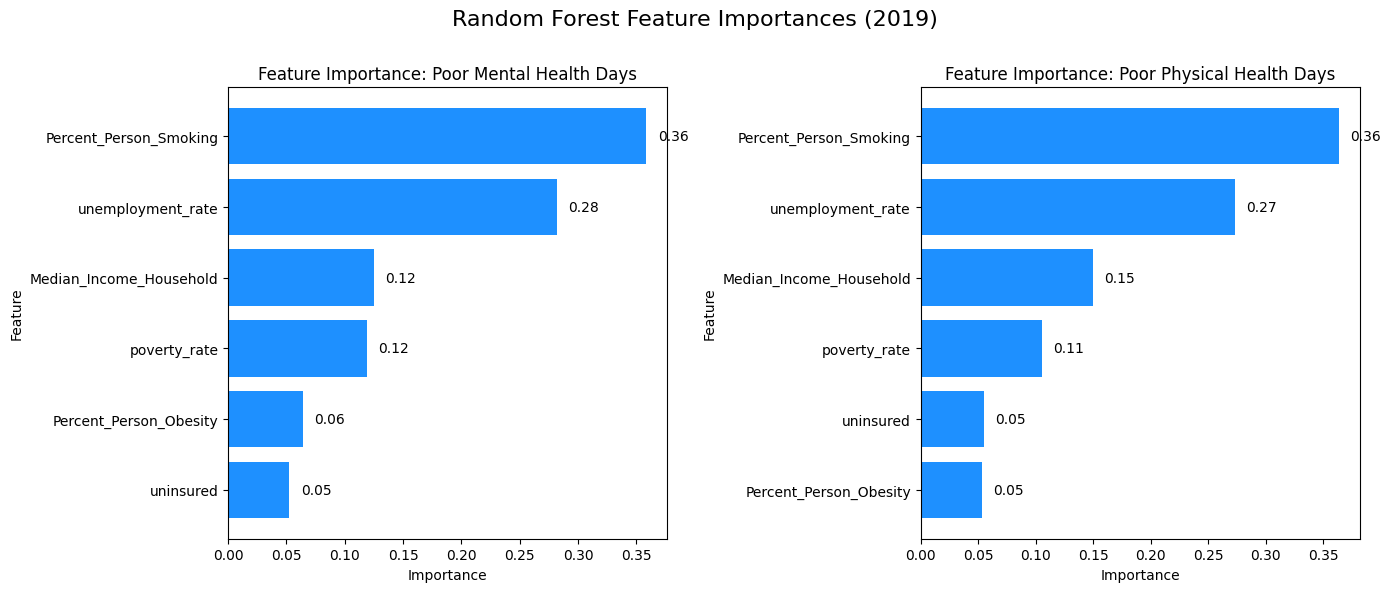

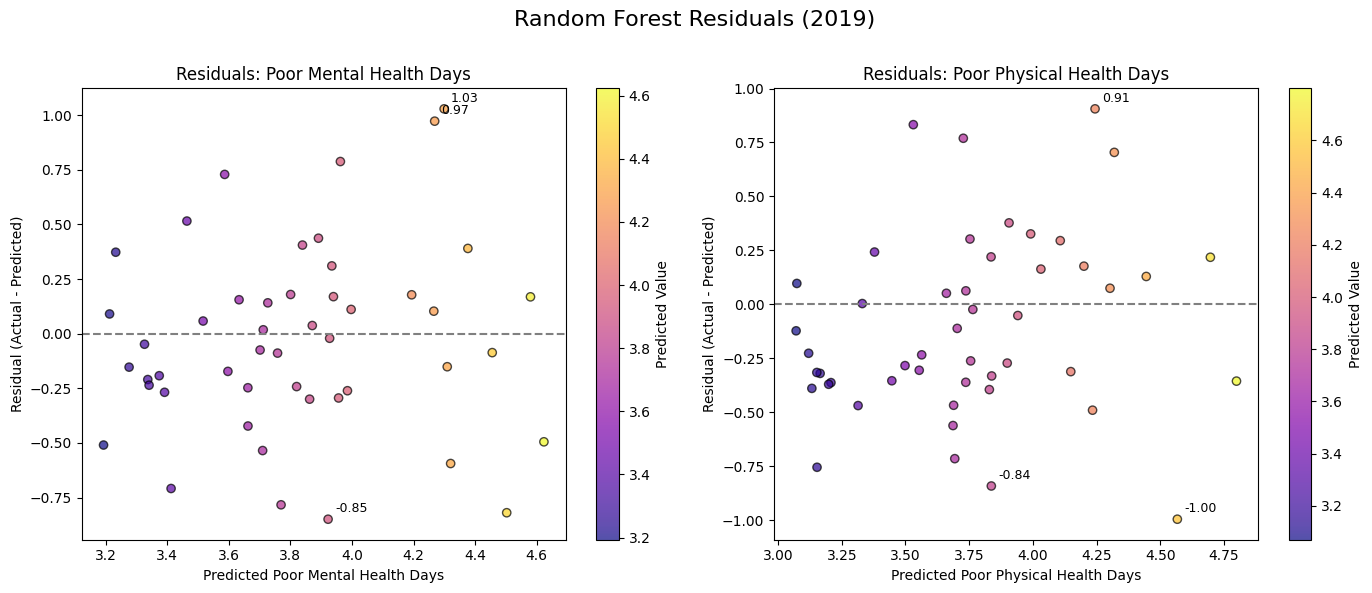

Processing year: 2020
poor_mental_health_days: RMSE = 0.31, R² = 0.61
poor_physical_health_days: RMSE = 0.37, R² = 0.60


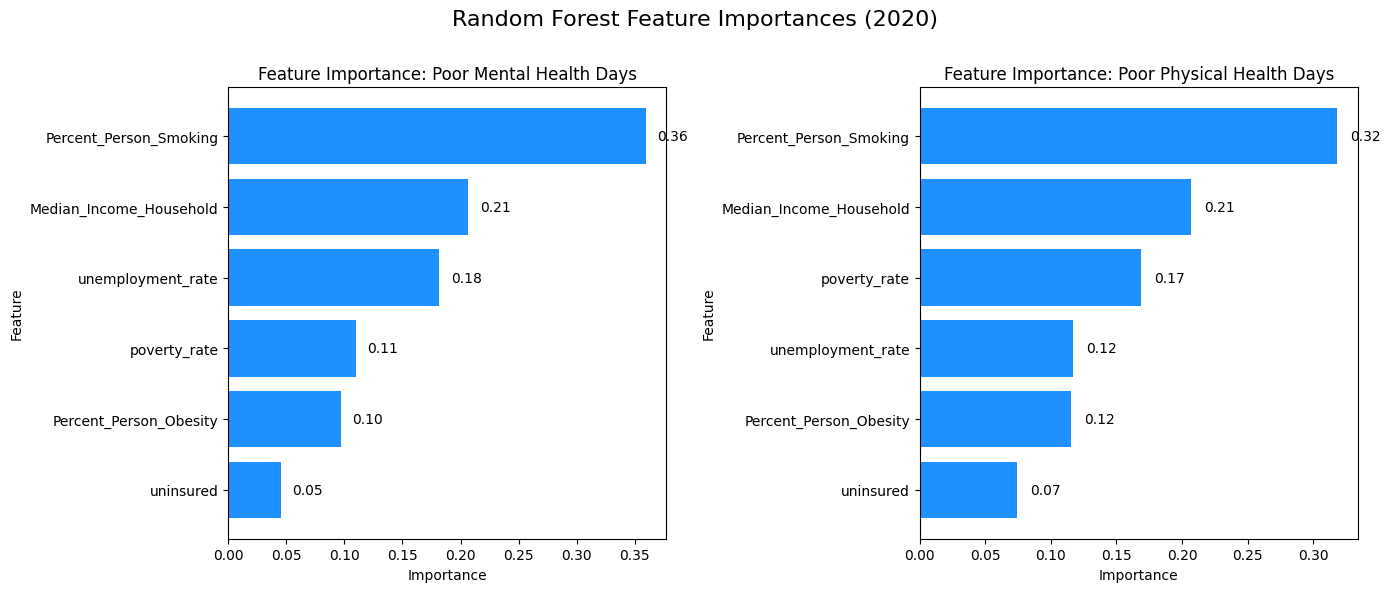

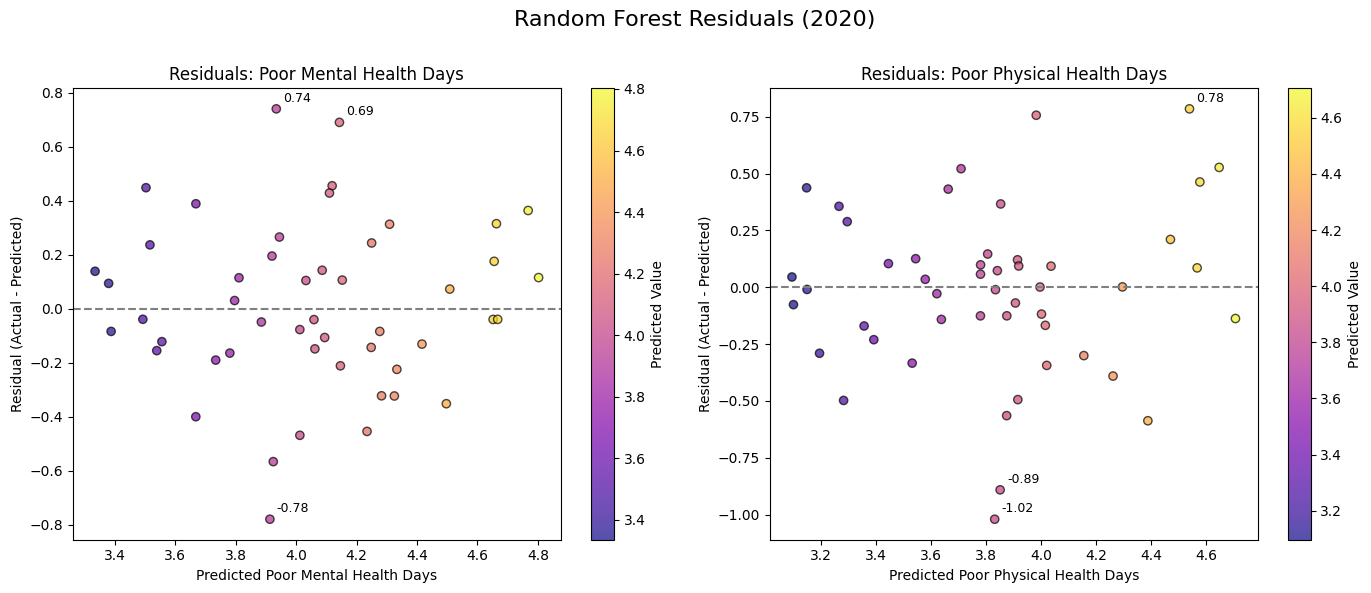

Processing year: 2021
poor_mental_health_days: RMSE = 0.46, R² = 0.51
poor_physical_health_days: RMSE = 0.49, R² = 0.60


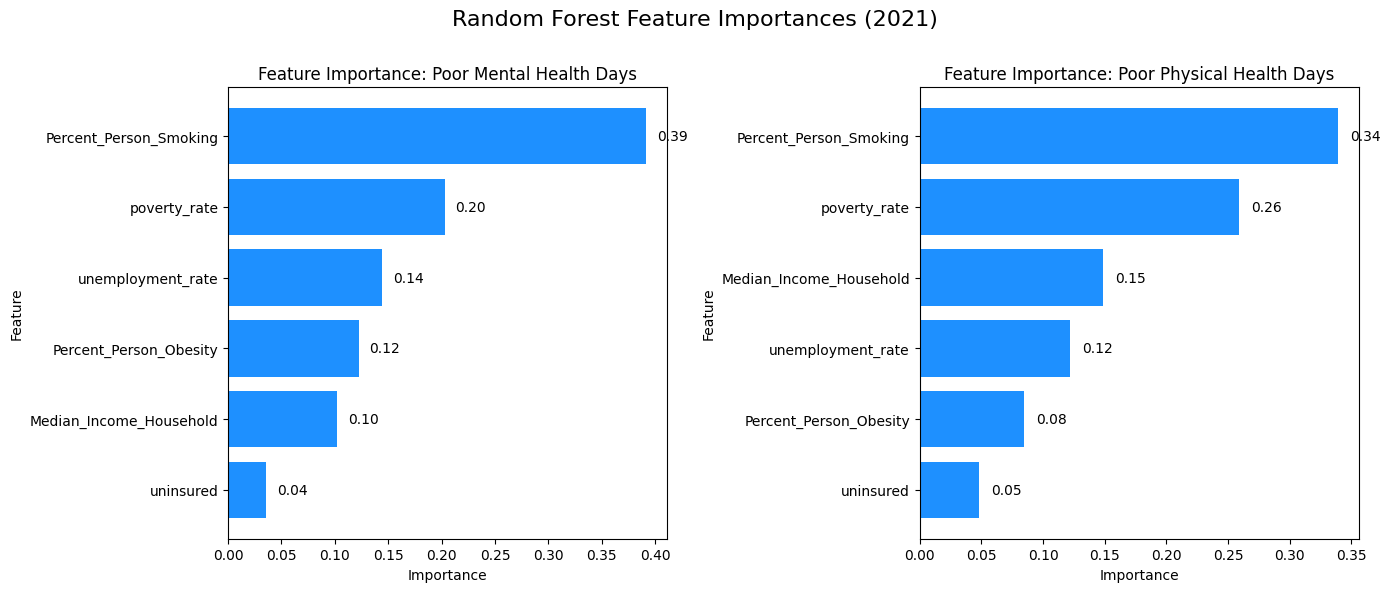

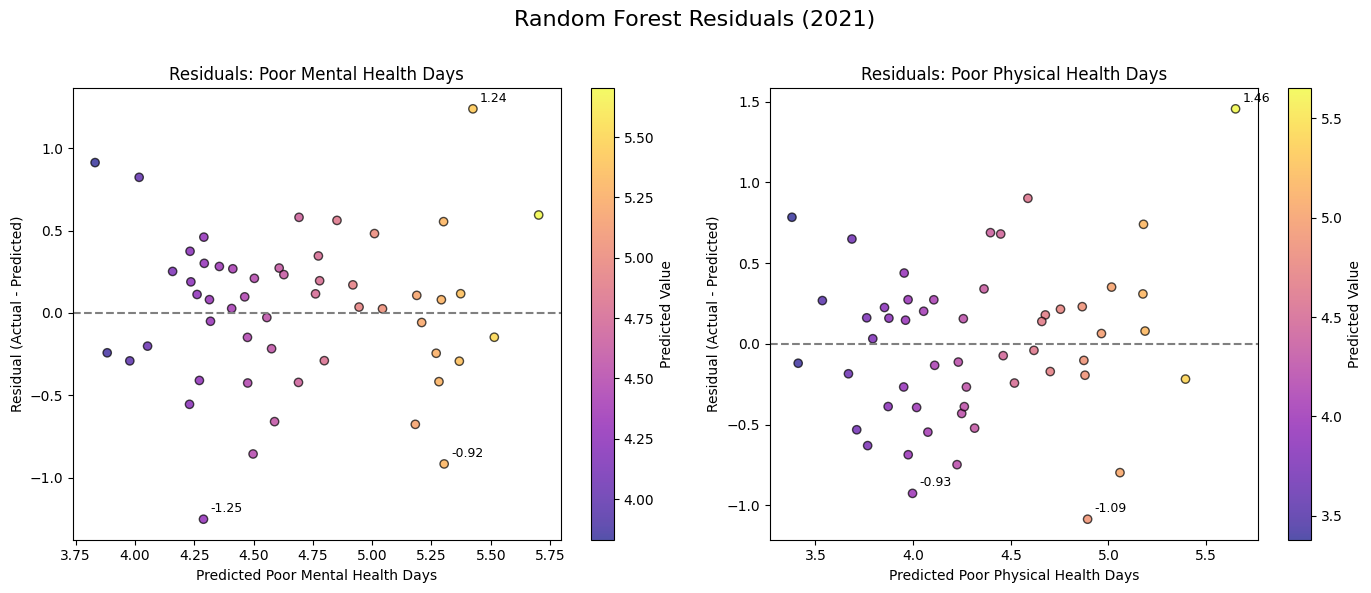

Processing year: 2022
poor_mental_health_days: RMSE = 0.44, R² = 0.59
poor_physical_health_days: RMSE = 0.43, R² = 0.70


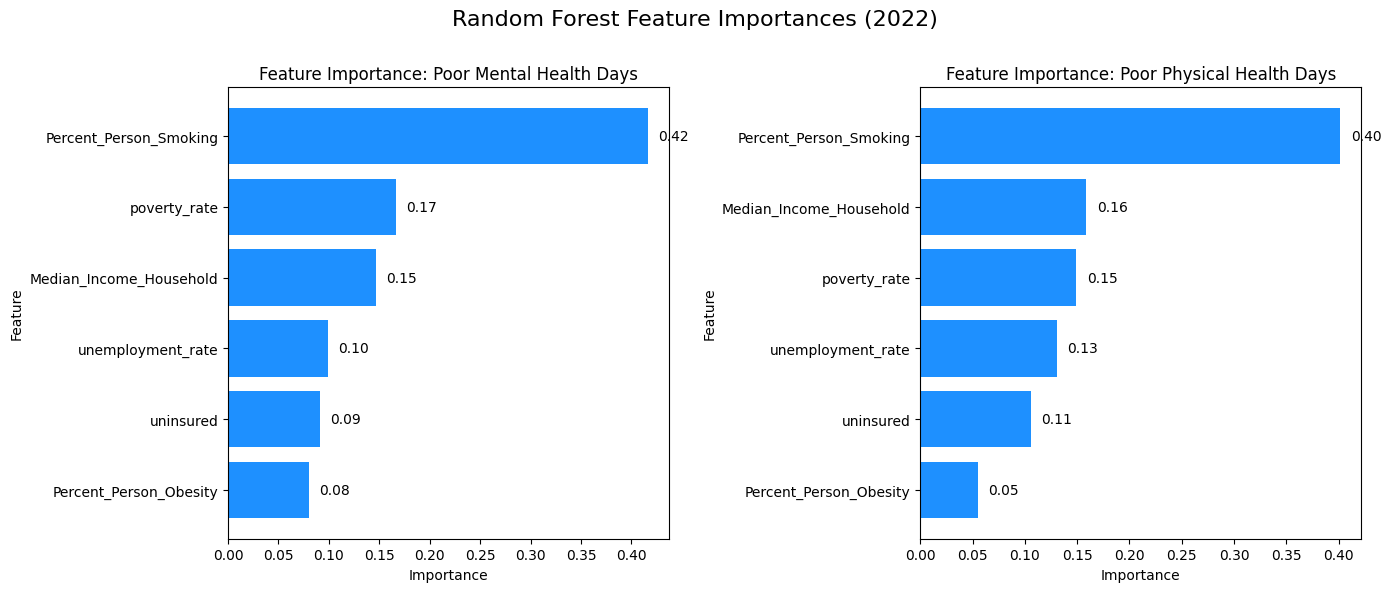

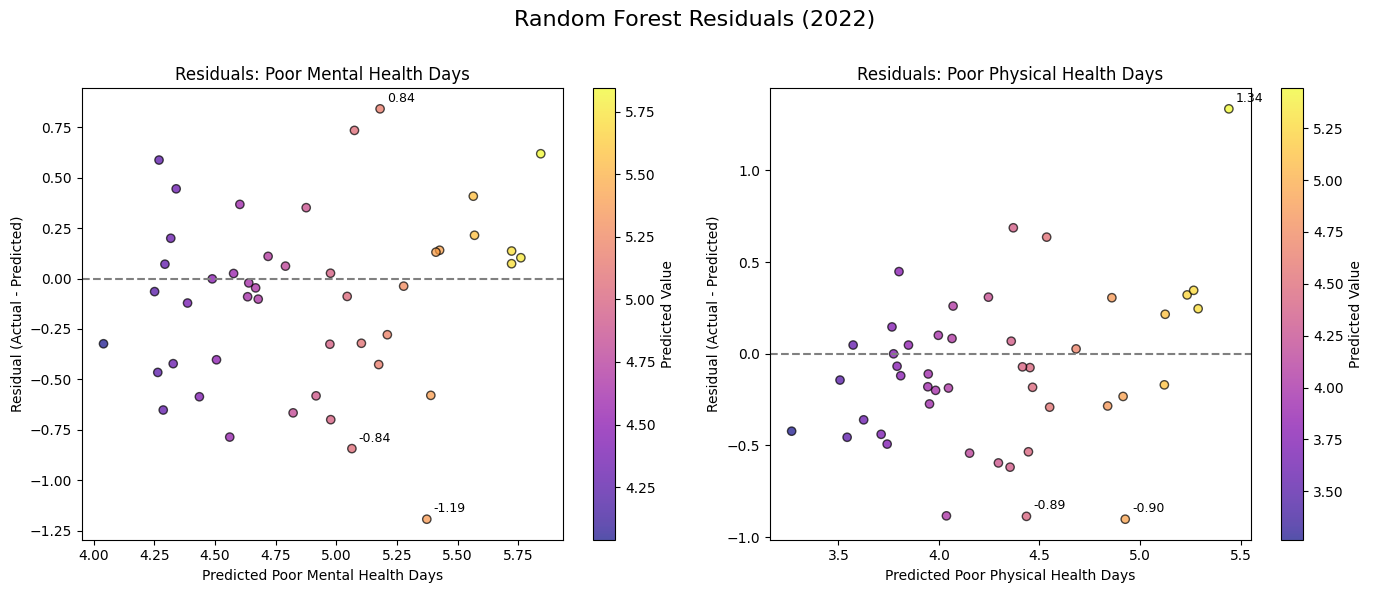

Processing year: 2023
No data for year 2023
Processing year: 2024
No data for year 2024
Processing year: 2025
No data for year 2025


In [305]:
# multioutput random forest for poor mental & physical health days
sample_size = 3000 
years = [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025] 

feature_names = [
    'poverty_rate', 'unemployment_rate', 'uninsured',
    'Percent_Person_Obesity', 'Percent_Person_Smoking', 'Median_Income_Household'
]
target_names = ['poor_mental_health_days', 'poor_physical_health_days']

for yr in years:
    print(f"Processing year: {yr}")
    query = f"""
    SELECT
      p.fips5, p.year, p.poverty_rate,
      u.unemployment_rate,
      h.poor_mental_health_days, h.poor_physical_health_days, h.uninsured,
      h.ratio_primary_care_physicians, h.ratio_mental_health_providers,
      h.population,
      c.Percent_Person_Obesity, c.Percent_Person_Smoking, c.Median_Income_Household,
      c.population_density_log10
    FROM read_csv_auto('{poverty_path}') p
    LEFT JOIN read_csv_auto('{unemployment_path}') u
      ON p.fips5 = u.fips5 AND p.year = u.year
    LEFT JOIN read_csv_auto('{health_path}') h
      ON p.fips5 = h.fips5 AND p.year = h.year
    LEFT JOIN read_csv_auto('{conus_path}') c
      ON p.fips5 = c.fips5
    WHERE p.year = {yr}
    USING SAMPLE {sample_size} ROWS
    """
    with duckdb.connect() as con:
        df_sample = con.execute(query).df()
    if df_sample.empty:
        print(f"No data for year {yr}")
        continue

    df_sample.head()
    
    X = df_sample[feature_names]
    y = df_sample[target_names]
    imputer_X = SimpleImputer(strategy='mean')
    imputer_y = SimpleImputer(strategy='mean')
    X_imputed = pd.DataFrame(imputer_X.fit_transform(X), columns=X.columns)
    y_imputed = pd.DataFrame(imputer_y.fit_transform(y), columns=y.columns)

    X_train, X_test, y_train, y_test = train_test_split(
        X_imputed, y_imputed, test_size=0.2, random_state=42
    )

    rf = RandomForestRegressor(
        n_estimators=100,
        max_depth=15,
        max_features='sqrt',
        min_samples_leaf=8,
        n_jobs=-1,
        random_state=42
    )
    multi_rf = MultiOutputRegressor(rf, n_jobs=-1)
    multi_rf.fit(X_train, y_train)
    y_pred = multi_rf.predict(X_test)

    for i, target in enumerate(target_names):
        mse = mean_squared_error(y_test.iloc[:, i], y_pred[:, i])
        rmse = mse**0.5
        r2 = r2_score(y_test.iloc[:, i], y_pred[:, i])
        print(f"{target}: RMSE = {rmse:.2f}, R² = {r2:.2f}")

    
    # feature importance plot --
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    for i, target in enumerate(target_names):
        importances = multi_rf.estimators_[i].feature_importances_
        sorted_idx = importances.argsort()
        bars = axes[i].barh([feature_names[j] for j in sorted_idx], importances[sorted_idx], color='dodgerblue')
        axes[i].set_title(f'Feature Importance: {target.replace("_", " ").title()}')
        axes[i].set_xlabel('Importance')
        axes[i].set_ylabel('Feature')
        for bar in bars:
            width = bar.get_width()
            axes[i].text(width + 0.01, bar.get_y() + bar.get_height()/2, f"{width:.2f}", va='center', fontsize=10, color='black')
    plt.suptitle(f'Random Forest Feature Importances ({yr})', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()
    
    # residuals -- 
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    n_plot = 400 
    for i, target in enumerate(target_names):
        residuals = y_test.iloc[:, i] - y_pred[:, i]
        y_pred_col = y_pred[:, i]
        if len(residuals) > n_plot:
            plot_idx = np.random.choice(len(residuals), n_plot, replace=False)
        else:
            plot_idx = np.arange(len(residuals))

        sc = axes[i].scatter(y_pred_col[plot_idx], residuals.iloc[plot_idx], c=y_pred_col[plot_idx], cmap='plasma', alpha=0.7, edgecolor='k')
        plt.colorbar(sc, ax=axes[i], label='Predicted Value')
        axes[i].axhline(0, color='gray', linestyle='--')
        axes[i].set_xlabel(f'Predicted {target.replace("_", " ").title()}')
        axes[i].set_ylabel('Residual (Actual - Predicted)')
        axes[i].set_title(f'Residuals: {target.replace("_", " ").title()}')
        abs_resid = np.abs(residuals.iloc[plot_idx].to_numpy())
        top_idx = abs_resid.argsort()[-3:]
        for idx in top_idx:
            axes[i].annotate(f"{residuals.iloc[plot_idx[idx]]:.2f}", (y_pred_col[plot_idx[idx]], residuals.iloc[plot_idx[idx]]), fontsize=9, 
                             color='black', xytext=(5,5), textcoords='offset points')
    plt.suptitle(f'Random Forest Residuals ({yr})', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

    del df_sample, X, y, X_imputed, y_imputed, X_train, X_test, y_train, y_test, y_pred
    gc.collect()

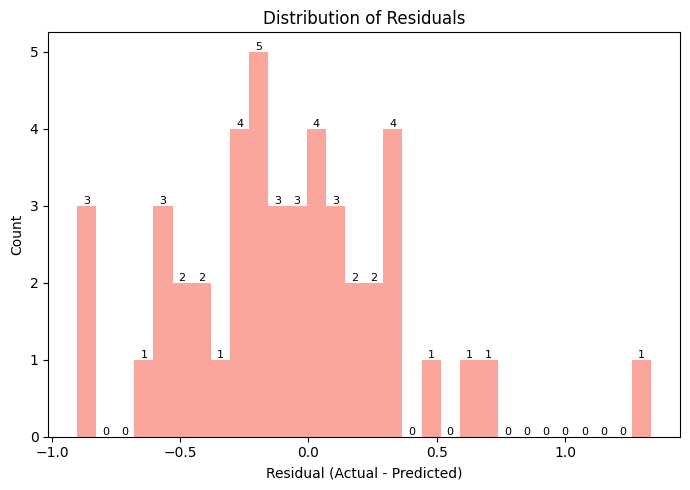

In [307]:
# histograms residuals
plt.figure(figsize=(7, 5))
n, bins, patches = plt.hist(residuals, bins=30, color='salmon', alpha=0.7)
for i in range(len(patches)):
    plt.text(patches[i].get_x() + patches[i].get_width()/2, n[i], str(int(n[i])),
             ha='center', va='bottom', fontsize=8)
plt.title('Distribution of Residuals')
plt.xlabel('Residual (Actual - Predicted)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [308]:
# histogram is roughly centered around zero w/ slight skew and a few outliers, mostly within (+/-)1 from 0

In [309]:
# interpretation -- Random Forest by year (2015-2025)

# RMSE values (0.31-0.51 for mental health, 0.36-0.50 for physical health) indicate strong prediction accuracy across years, close to actual

# mostly strong R^2 values (0.84-0.87 for mental health, 0.78-0.85 for physical health) with unexpected drop in 2022 (R²=0.50/0.60) -- 
# model captures most of the variation in poor mental, physical health days until 2022
# lack of information in 2023-2025, no RF possible

# feature importances show which factors most strongly predict poor mental health days (eg., poverty rate, unemployment, obesity, etc)
# in 2015-2016, Unemployment_rate is the most influential/dominant predictor 
# in 2017-2022, Percent_Person_Smoking is by far (importance score 0.45-0.46 by 2022) the most influential/dominant predictor 
# Unemployment_rate is also consistently important (0.12-0.24), while poverty_rate, Median_income_household, and uninsured play
# smaller & varying but still relevant roles
# feature importance rankings is/remains consistent between mental & physical health models

# Smoking rates are highly predictive of poor mental, physical health days at the county level
# Economic factors (unemployment, poverty, income) and insurance coverage also matter, but their influences are smaller and vary by year
# Percent_Person_Smoking, unemployment_rate & poverty_rate was most important in 2015–2016, but Percent_Person_Smoking became more important from 2017 onward
# this suggests changes in the indicators/factors/drivers of poor mental health at the population level, or changes in data quality/availability
# also note: CHR data lacked a lot of data for other health indicators & outcomes despite existence of intended measures for 10+ years


# interpretation -- residuals by year (2015-2025)

# in 2015-2022, residuals are generally scattered around zero (relatively even distribution), but there is some more spread especially at 
# higher predicted values (right side of each plot) there is spread -- residual patterns remain stable across 2015-2021 with some changes in 2022
# no obvious systematic bias, patterns, trends; randomly dispersed with no clear curve or clustering


# OVERALL interpretation --

## Model performance is strong and stable for 2015-2021; 2022 onward shows differences or lack of data
# Smoking is dominant predictor for both mental and physical health from 2017 onward -- indicates critical role in population health
# Unemployment, poverty rates, household income are secondary strongest predictors of poor health days
# Consistent feature importance patterns suggest reliable identification of health determinants
# -- can further examine 2022-2025 in later studies

## other health outcomes & factors, and other unmeasured influences can be modeled as long as datasets appropriate for longitudinal study (2015-2025)
## exist -- CONUS27 has interesting features measured, but were not annual (limitation/issue) so could not model for longitudinal study as intended